In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install scikit-learn pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attempt

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.neighbors import kneighbors_graph

from torch.nn import Linear, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch_geometric.nn import GATConv

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x

In [5]:
import pandas as pd
import joblib
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def create_graph(X, k=5):
    from sklearn.neighbors import kneighbors_graph
    import numpy as np
    adj = kneighbors_graph(X, k, mode='connectivity', include_self=False)
    edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)
    return edge_index

def evaluate_gnn_on_test(test_file_path, model_class, model_state_dict, scaler_file, label_encoder_file, school_mapping_file=None, k=5):
    # Load assets
    scaler = joblib.load(scaler_file)
    label_encoder = joblib.load(label_encoder_file)
    school_mapping = joblib.load(school_mapping_file) if school_mapping_file else None

    # Load test data
    df = pd.read_csv(test_file_path)
    y_test = df['label_encoded'].values
    X_test = df.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], errors='ignore')

    # Encode school
    if school_mapping and 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(school_mapping).fillna(0).astype(int)

    # Scale features
    X_scaled = scaler.transform(X_test)

    # Create graph
    edge_index = create_graph(X_scaled, k=k)

    # Construct PyG data
    data = Data(
        x=torch.tensor(X_scaled, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y_test, dtype=torch.long)
    ).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Model init and load weights
    model = model_class(data.num_node_features, hidden_channels=32, out_channels=len(label_encoder.classes_))
    model.load_state_dict(torch.load(model_state_dict, map_location='cpu'))
    model.eval()
    model.to(data.x.device)

    # Predict
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        y_proba = F.softmax(logits, dim=1).cpu().numpy()
        y_pred = logits.argmax(dim=1).cpu().numpy()

    # Decode labels
    y_true = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score + ROC Curves
    y_true_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
    auc_score = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred_labels

In [6]:
def train_phase(phase_path, hidden_dim=32, epochs=100, lr=1e-3, k=5, random_state=42, sample=False):
    all_metrics = []
    best_model_state = None
    best_score = 0
    best_scaler = None  
    best_label_encoder = None 

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

        # Encode labels
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        y_val_enc = label_encoder.transform(y_val)
        class_names = label_encoder.classes_
        num_classes = len(class_names)

        # Combine train + val to form full graph
        X_all = pd.concat([X_train, X_val], axis=0)
        y_all_enc = np.concatenate([y_train_enc, y_val_enc])
        val_mask = torch.zeros(len(X_all), dtype=torch.bool)
        val_mask[len(X_train):] = True
        train_mask = ~val_mask

        # Build edge index
        edge_index = create_graph(X_all.values, k=k)

        data = Data(
            x=torch.tensor(X_all.values, dtype=torch.float32),
            y=torch.tensor(y_all_enc, dtype=torch.long),
            edge_index=edge_index,
            train_mask=train_mask,
            val_mask=val_mask
        ).to(device)

        model = GATModel(X_all.shape[1], hidden_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = CrossEntropyLoss()

        # Training loop
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        logits = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred = label_encoder.inverse_transform(preds[val_mask.cpu()])
        y_true = label_encoder.inverse_transform(data.y[val_mask].cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        # AUC
        y_proba = F.softmax(logits[val_mask], dim=1).cpu().detach().numpy()
        y_true_bin = label_binarize(label_encoder.transform(y_true), classes=np.arange(num_classes))
        auc = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model_state = model.state_dict()
            best_scaler = scaler  # Save this scaler
            best_label_encoder = label_encoder

        # Visuals (optional to disable for faster runs)
        print(f"\nFold {fold} Classification Report:\n", classification_report(y_true, y_pred))
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # ROC Curve
        plt.figure(figsize=(8, 6))
        for i, label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {label}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    avg = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg['f1_macro']:.4f}")
    print(f"Average AUC: {avg['auc']:.4f}")

    return best_model_state, best_scaler, best_label_encoder, all_metrics



======= Training Phase 1 ========



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      1785
           1       0.31      0.06      0.10       604
           2       0.27      0.03      0.06       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.65      2715
   macro avg       0.25      0.21      0.19      2715
weighted avg       0.54      0.65      0.55      2715



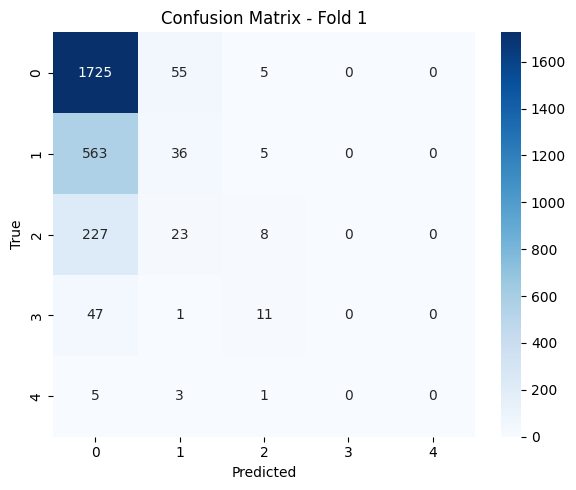

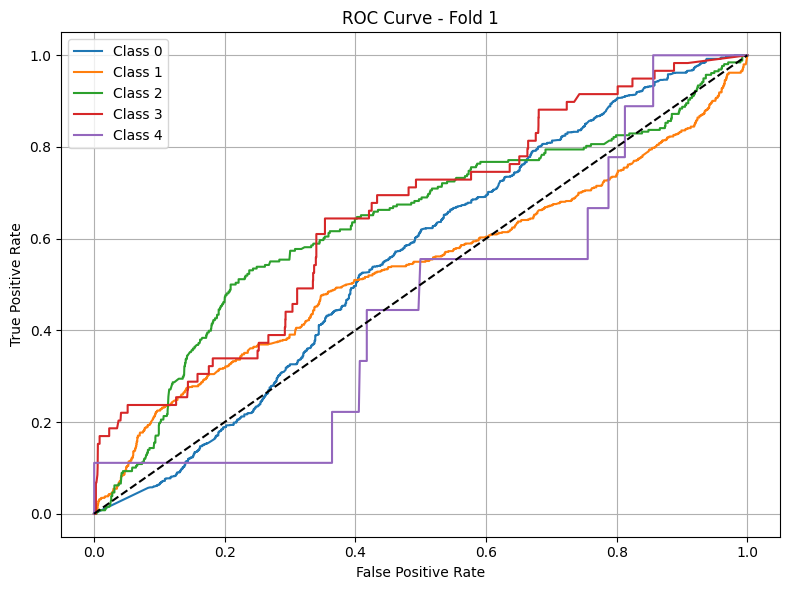

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.95      0.79      1786
           1       0.34      0.10      0.15       603
           2       0.22      0.04      0.07       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         8

    accuracy                           0.65      2714
   macro avg       0.25      0.22      0.20      2714
weighted avg       0.54      0.65      0.56      2714



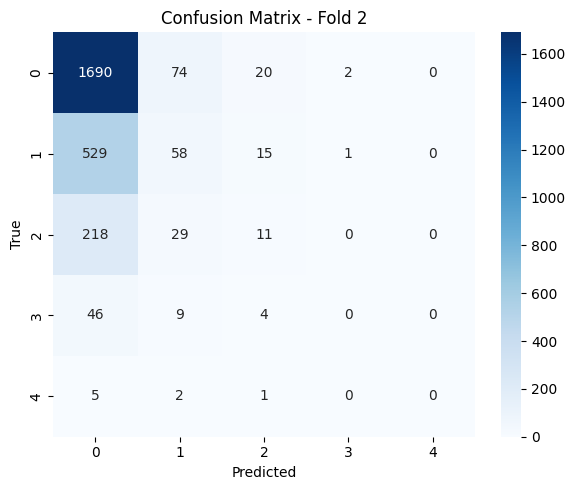

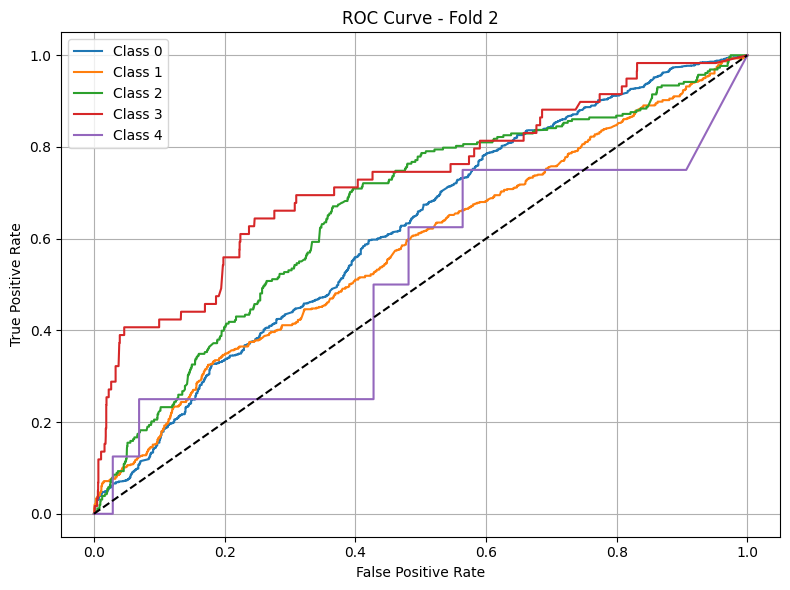

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.85      0.76      1786
           1       0.33      0.25      0.29       603
           2       0.33      0.05      0.09       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         8

    accuracy                           0.62      2714
   macro avg       0.27      0.23      0.23      2714
weighted avg       0.55      0.62      0.57      2714



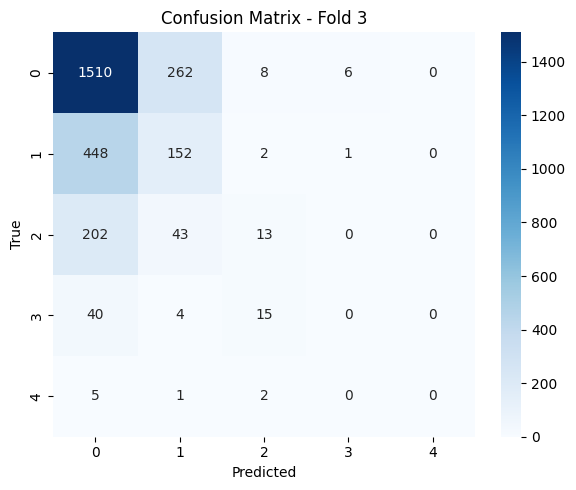

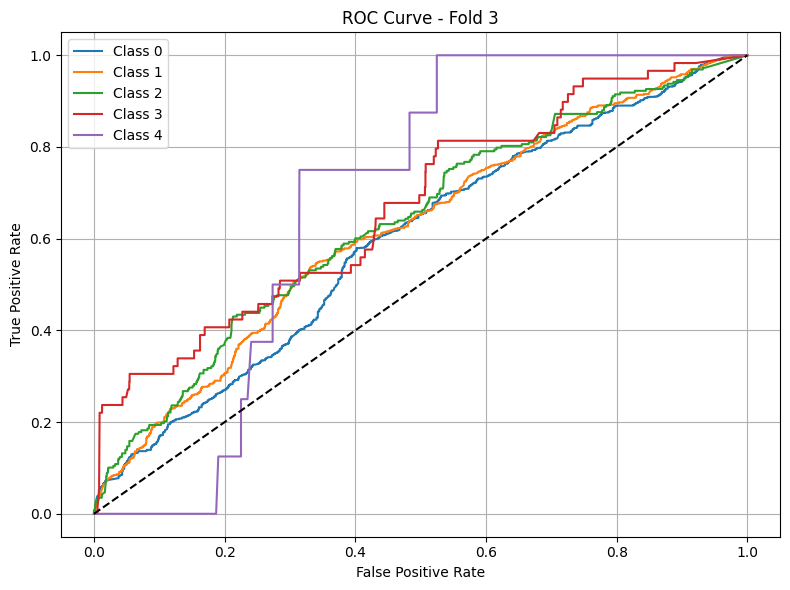

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.87      0.75      1785
           1       0.26      0.14      0.18       603
           2       0.37      0.07      0.12       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.61      2714
   macro avg       0.26      0.22      0.21      2714
weighted avg       0.53      0.61      0.55      2714



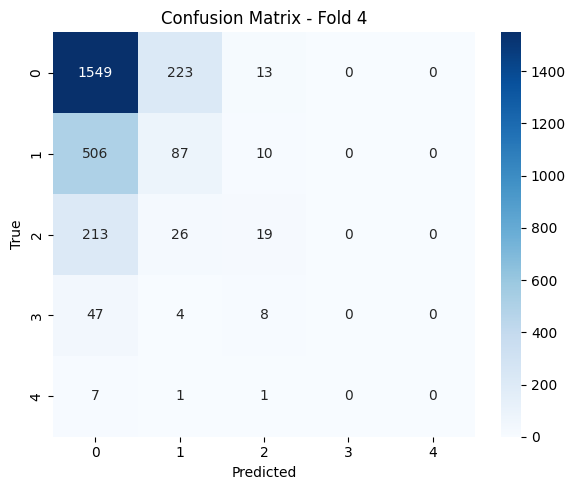

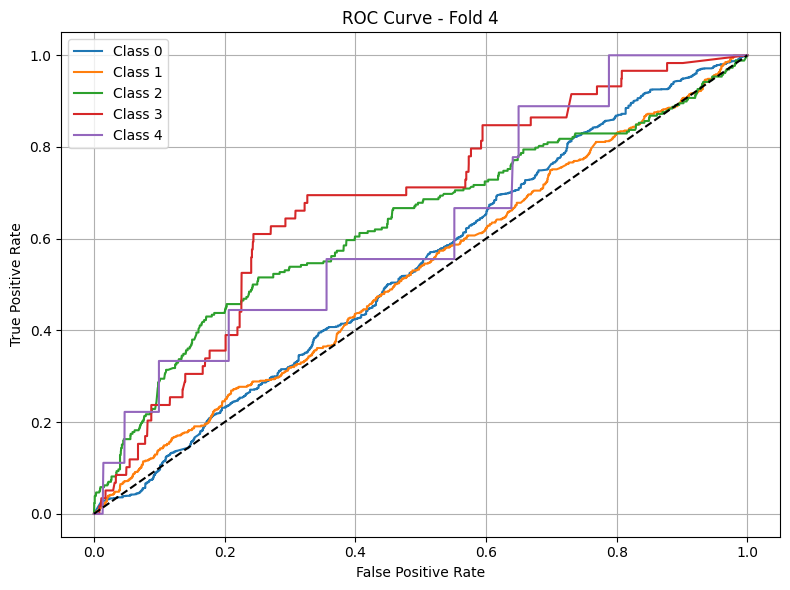

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.96      0.80      1785
           1       0.44      0.07      0.13       603
           2       0.33      0.10      0.15       258
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00         9

    accuracy                           0.66      2714
   macro avg       0.29      0.23      0.21      2714
weighted avg       0.58      0.66      0.57      2714



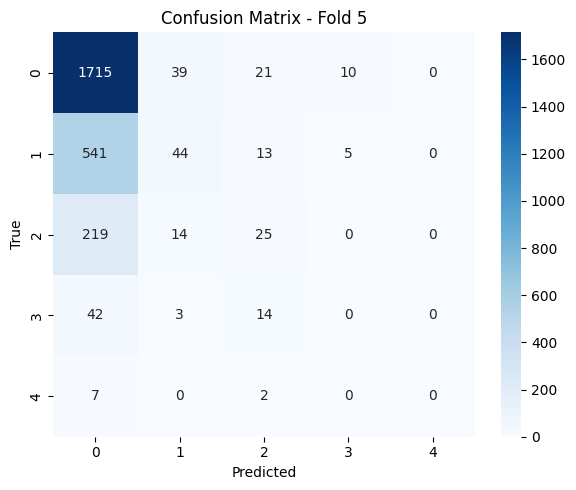

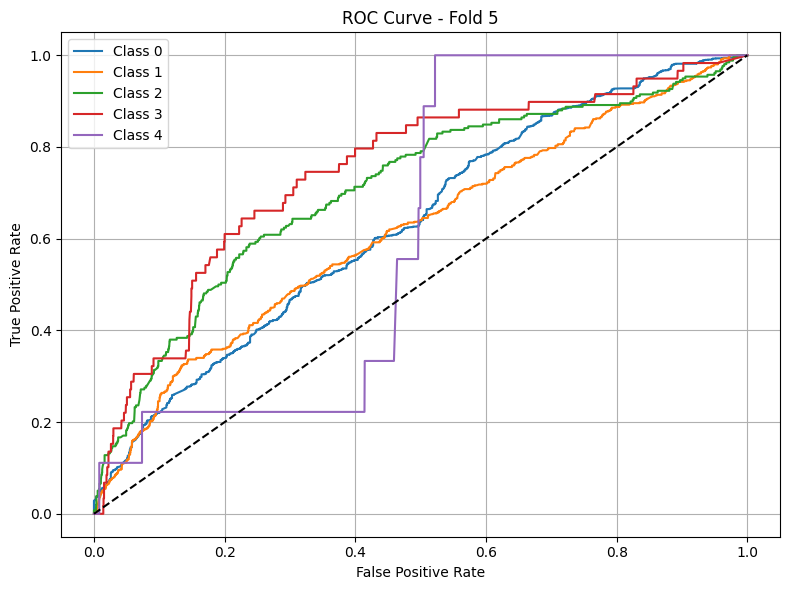


Average Accuracy: 0.6368
Average F1 Macro: 0.2089
Average AUC: 0.6179
{'phase1': [{'fold': 1, 'accuracy': 0.6515653775322283, 'f1_macro': 0.18960350356670835, 'auc': 0.565006558128834}, {'fold': 2, 'accuracy': 0.6481208548268239, 'f1_macro': 0.202340618855892, 'auc': 0.619295875145724}, {'fold': 3, 'accuracy': 0.6171702284450995, 'f1_macro': 0.22587938246882752, 'auc': 0.6401149969171389}, {'fold': 4, 'accuracy': 0.6098010316875461, 'f1_macro': 0.21232425392672938, 'auc': 0.6006235010238729}, {'fold': 5, 'accuracy': 0.6573323507737656, 'f1_macro': 0.2142672628290246, 'auc': 0.6644938923745644}]}


======= Training Phase 2 ========



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      1489
           1       0.27      0.05      0.08       488
           2       0.24      0.05      0.08       220
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         9

    accuracy                           0.65      2260
   macro avg       0.24      0.21      0.19      2260
weighted avg       0.53      0.65      0.55      2260



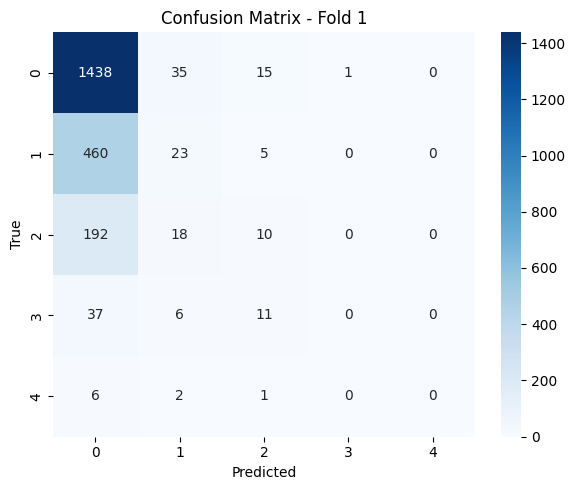

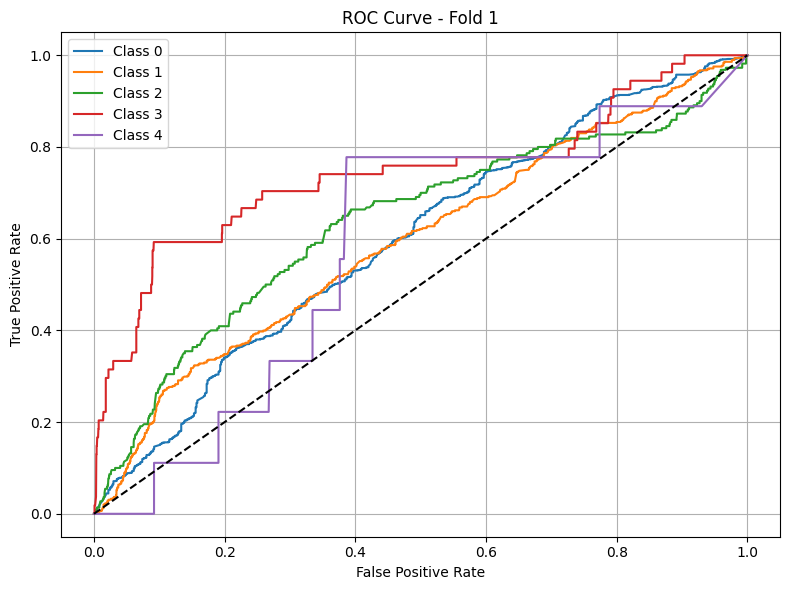

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79      1489
           1       0.27      0.02      0.03       489
           2       0.32      0.11      0.16       219
           3       0.00      0.00      0.00        55
           4       0.00      0.00      0.00         8

    accuracy                           0.65      2260
   macro avg       0.25      0.22      0.20      2260
weighted avg       0.53      0.65      0.54      2260



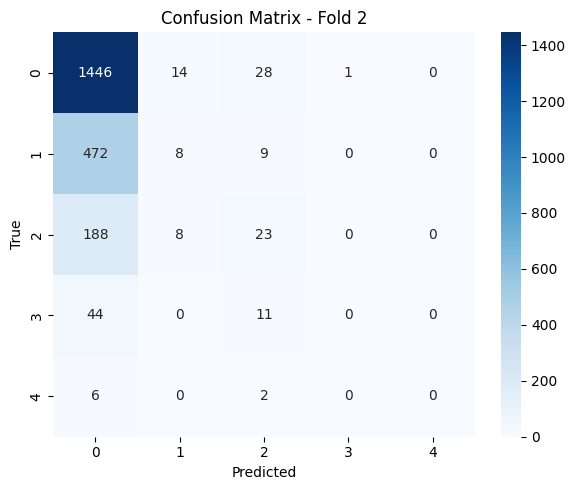

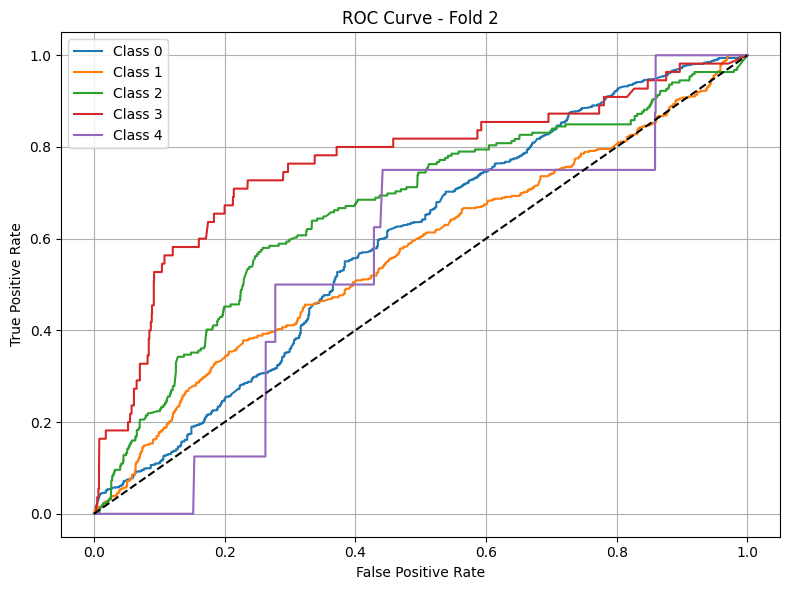


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.90      0.77      1489
           1       0.21      0.04      0.07       489
           2       0.18      0.13      0.15       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.62      2259
   macro avg       0.21      0.22      0.20      2259
weighted avg       0.51      0.62      0.54      2259



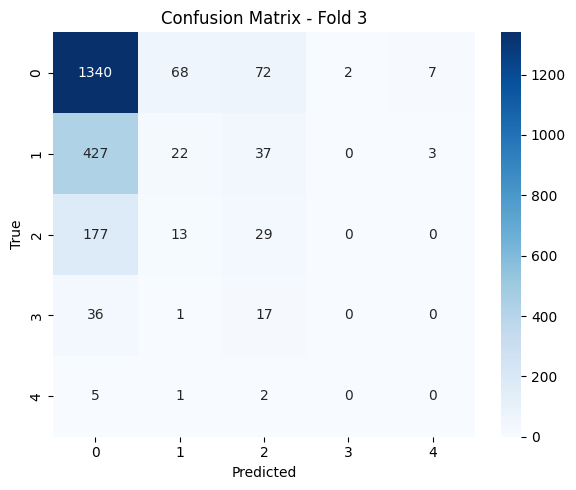

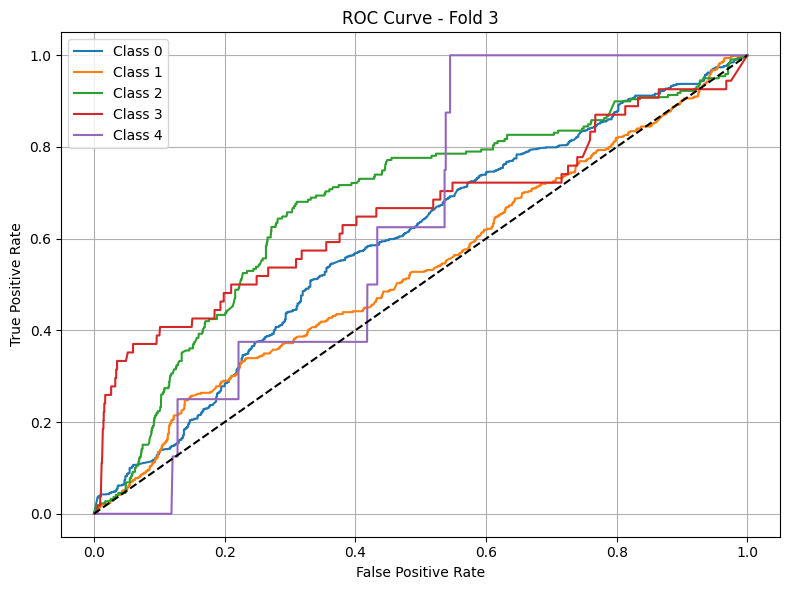

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.92      0.78      1489
           1       0.27      0.09      0.13       489
           2       0.23      0.08      0.12       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.63      2259
   macro avg       0.24      0.22      0.21      2259
weighted avg       0.53      0.63      0.56      2259



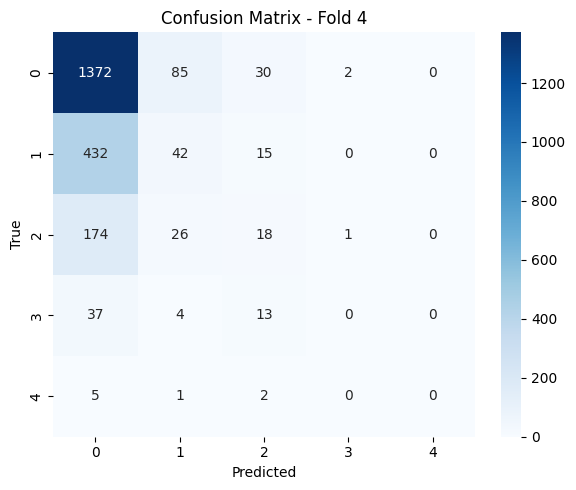

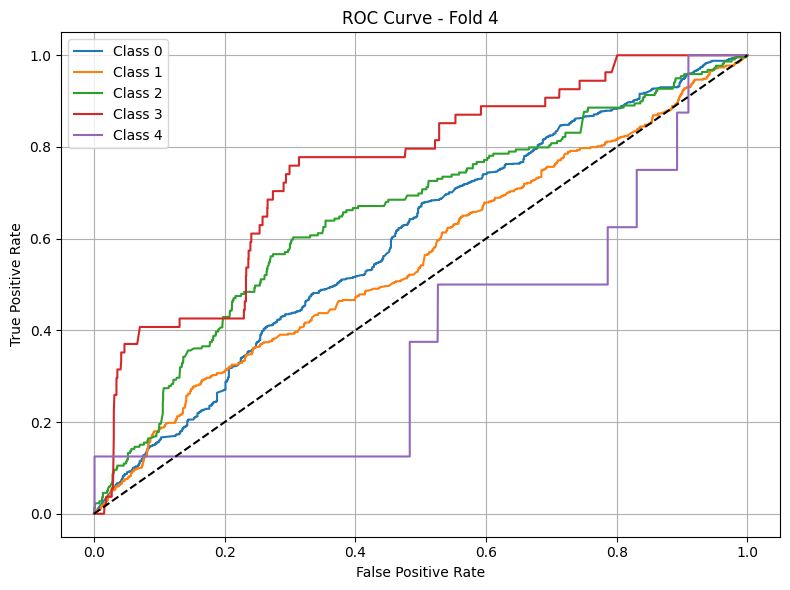


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.95      0.79      1490
           1       0.31      0.07      0.11       488
           2       0.24      0.05      0.08       219
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00         8

    accuracy                           0.64      2259
   macro avg       0.24      0.21      0.20      2259
weighted avg       0.53      0.64      0.55      2259



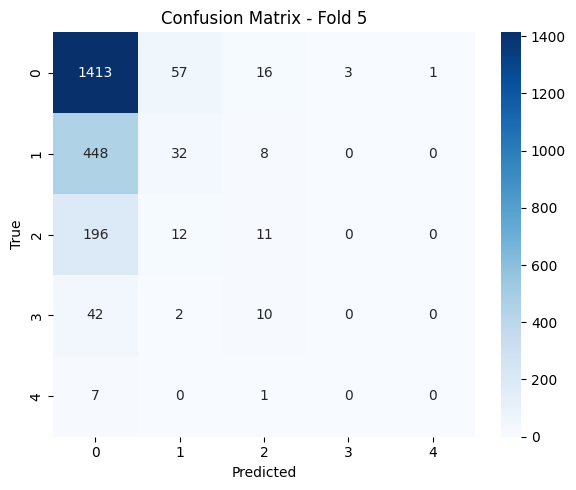

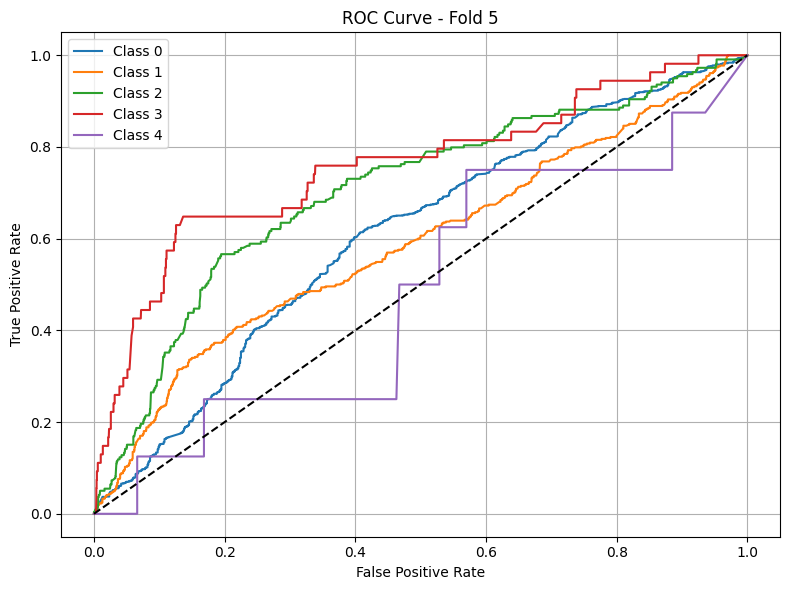


Average Accuracy: 0.6397
Average F1 Macro: 0.1977
Average AUC: 0.6194
{'phase1': [{'fold': 1, 'accuracy': 0.6515653775322283, 'f1_macro': 0.18960350356670835, 'auc': 0.565006558128834}, {'fold': 2, 'accuracy': 0.6481208548268239, 'f1_macro': 0.202340618855892, 'auc': 0.619295875145724}, {'fold': 3, 'accuracy': 0.6171702284450995, 'f1_macro': 0.22587938246882752, 'auc': 0.6401149969171389}, {'fold': 4, 'accuracy': 0.6098010316875461, 'f1_macro': 0.21232425392672938, 'auc': 0.6006235010238729}, {'fold': 5, 'accuracy': 0.6573323507737656, 'f1_macro': 0.2142672628290246, 'auc': 0.6644938923745644}], 'phase2': [{'fold': 1, 'accuracy': 0.6508849557522124, 'f1_macro': 0.19015838044715852, 'auc': 0.6307314397005991}, {'fold': 2, 'accuracy': 0.6535398230088496, 'f1_macro': 0.19635568016261482, 'auc': 0.6290521424753084}, {'fold': 3, 'accuracy': 0.6157591854803011, 'f1_macro': 0.1999548826745387, 'auc': 0.6187533196092444}, {'fold': 4, 'accuracy': 0.6339088092076139, 'f1_macro': 0.2066062552920

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.93      0.78      1361
           1       0.18      0.04      0.07       459
           2       0.35      0.09      0.14       198
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.24      0.21      0.20      2074
weighted avg       0.51      0.63      0.54      2074



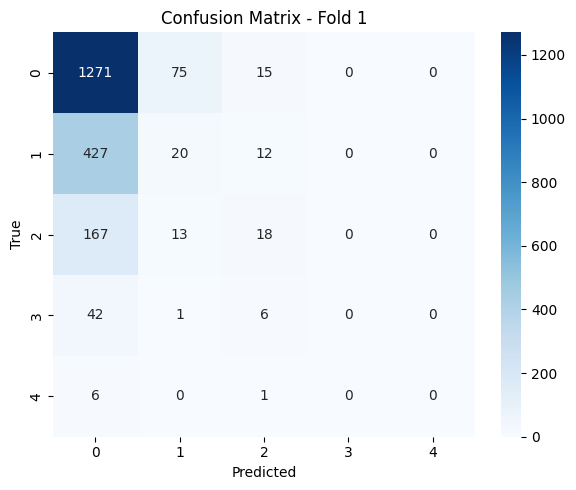

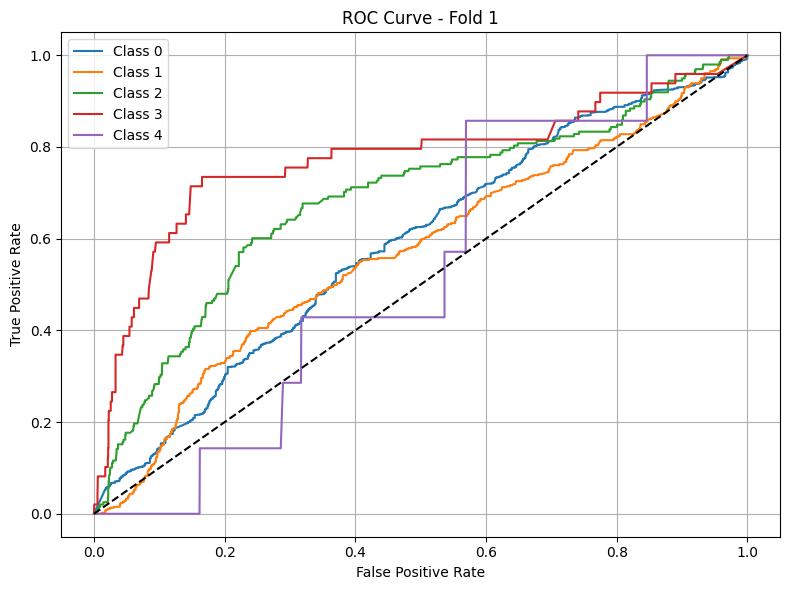

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.92      0.77      1360
           1       0.27      0.08      0.12       459
           2       0.18      0.06      0.09       198
           3       0.43      0.06      0.11        50
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.31      0.22      0.22      2074
weighted avg       0.53      0.63      0.55      2074



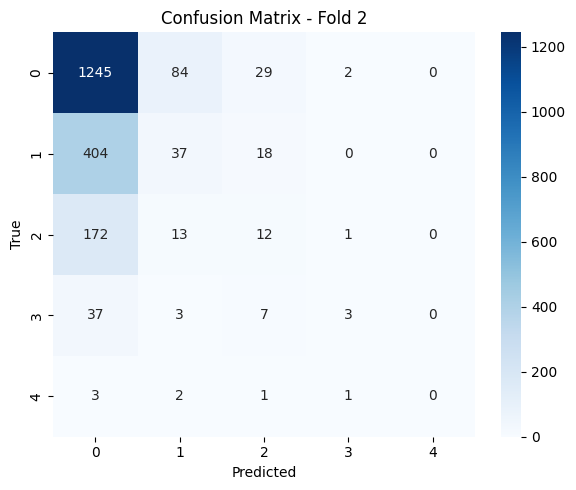

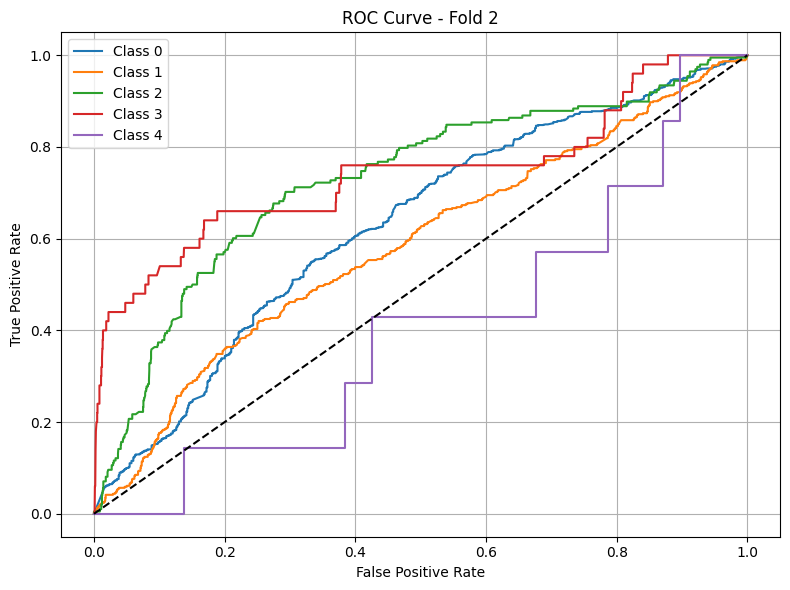


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80      1360
           1       0.44      0.04      0.08       459
           2       0.26      0.18      0.22       198
           3       0.60      0.06      0.11        50
           4       0.00      0.00      0.00         7

    accuracy                           0.65      2074
   macro avg       0.40      0.25      0.24      2074
weighted avg       0.59      0.65      0.56      2074



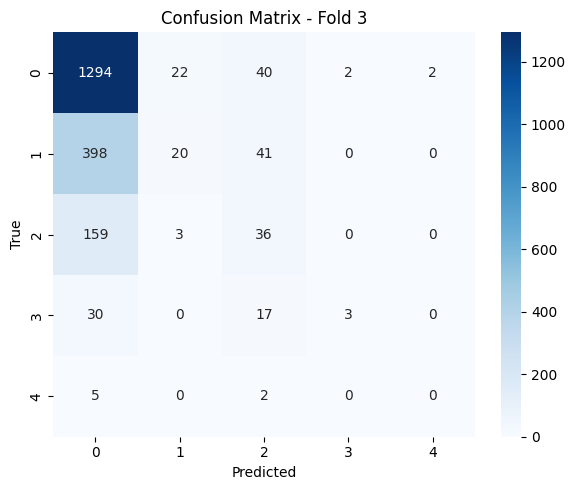

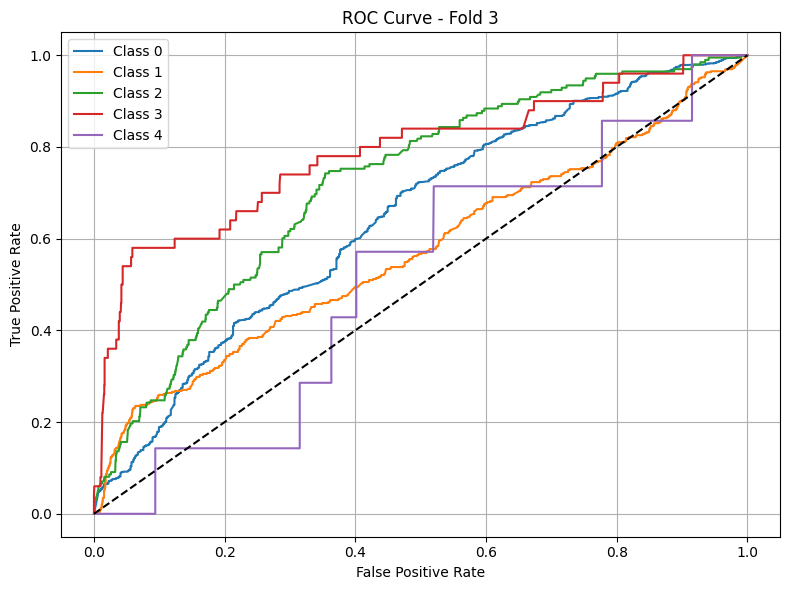

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77      1360
           1       0.20      0.07      0.10       459
           2       0.29      0.07      0.11       198
           3       0.00      0.00      0.00        50
           4       0.00      0.00      0.00         7

    accuracy                           0.62      2074
   macro avg       0.23      0.21      0.20      2074
weighted avg       0.51      0.62      0.54      2074



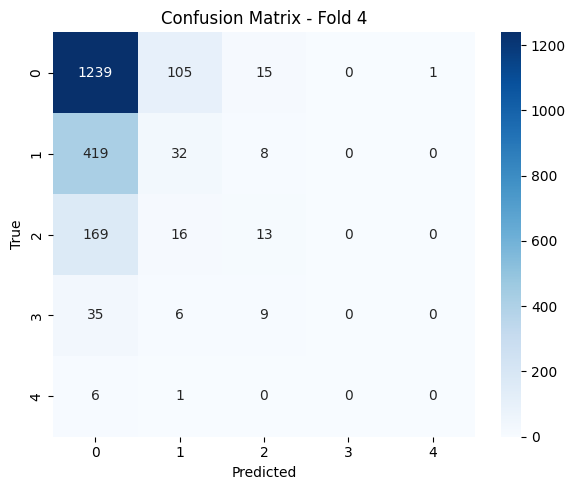

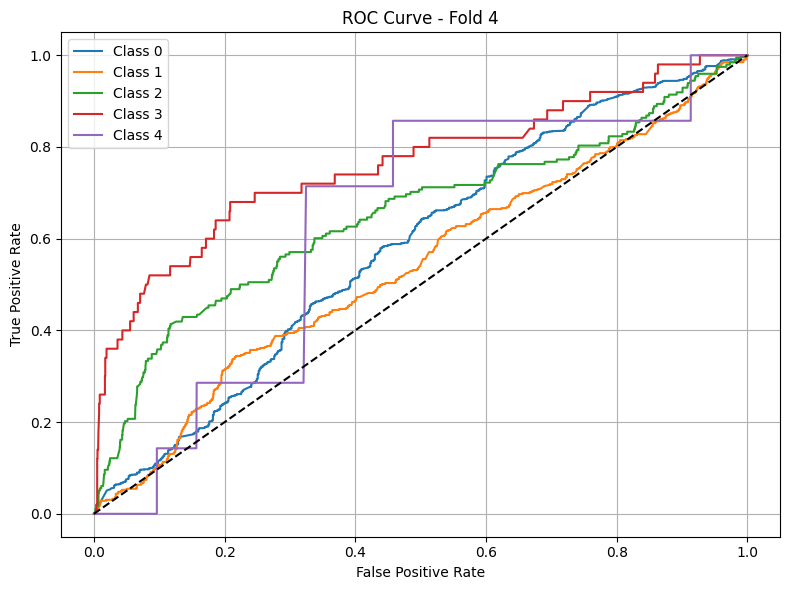

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.92      0.77      1360
           1       0.20      0.06      0.09       460
           2       0.22      0.04      0.07       197
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00         7

    accuracy                           0.62      2073
   macro avg       0.22      0.20      0.19      2073
weighted avg       0.50      0.62      0.53      2073



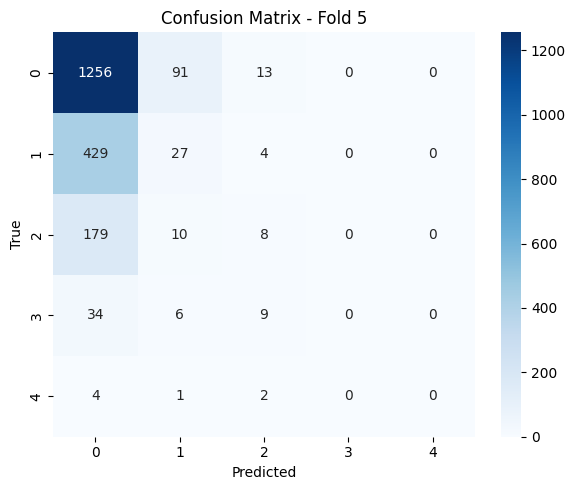

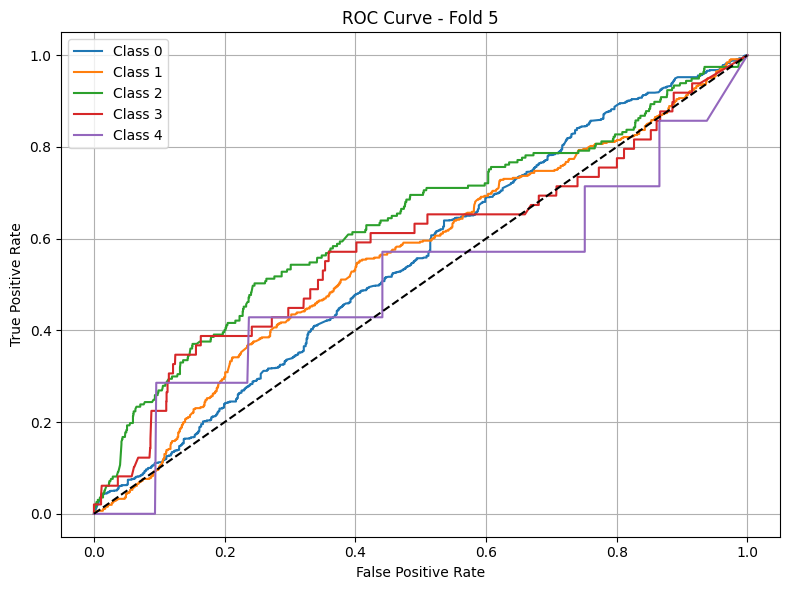


Average Accuracy: 0.6301
Average F1 Macro: 0.2077
Average AUC: 0.6195
{'phase1': [{'fold': 1, 'accuracy': 0.6515653775322283, 'f1_macro': 0.18960350356670835, 'auc': 0.565006558128834}, {'fold': 2, 'accuracy': 0.6481208548268239, 'f1_macro': 0.202340618855892, 'auc': 0.619295875145724}, {'fold': 3, 'accuracy': 0.6171702284450995, 'f1_macro': 0.22587938246882752, 'auc': 0.6401149969171389}, {'fold': 4, 'accuracy': 0.6098010316875461, 'f1_macro': 0.21232425392672938, 'auc': 0.6006235010238729}, {'fold': 5, 'accuracy': 0.6573323507737656, 'f1_macro': 0.2142672628290246, 'auc': 0.6644938923745644}], 'phase2': [{'fold': 1, 'accuracy': 0.6508849557522124, 'f1_macro': 0.19015838044715852, 'auc': 0.6307314397005991}, {'fold': 2, 'accuracy': 0.6535398230088496, 'f1_macro': 0.19635568016261482, 'auc': 0.6290521424753084}, {'fold': 3, 'accuracy': 0.6157591854803011, 'f1_macro': 0.1999548826745387, 'auc': 0.6187533196092444}, {'fold': 4, 'accuracy': 0.6339088092076139, 'f1_macro': 0.2066062552920

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.79      1000
           1       0.44      0.18      0.26       355
           2       0.43      0.06      0.11       139
           3       0.33      0.05      0.09        39
           4       0.00      0.00      0.00         6

    accuracy                           0.65      1539
   macro avg       0.38      0.25      0.25      1539
weighted avg       0.59      0.65      0.58      1539



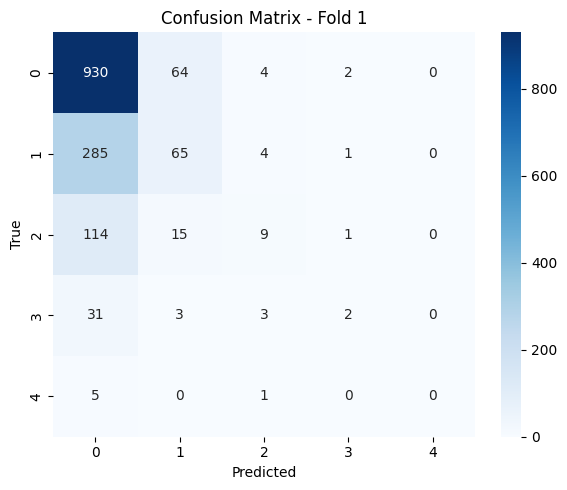

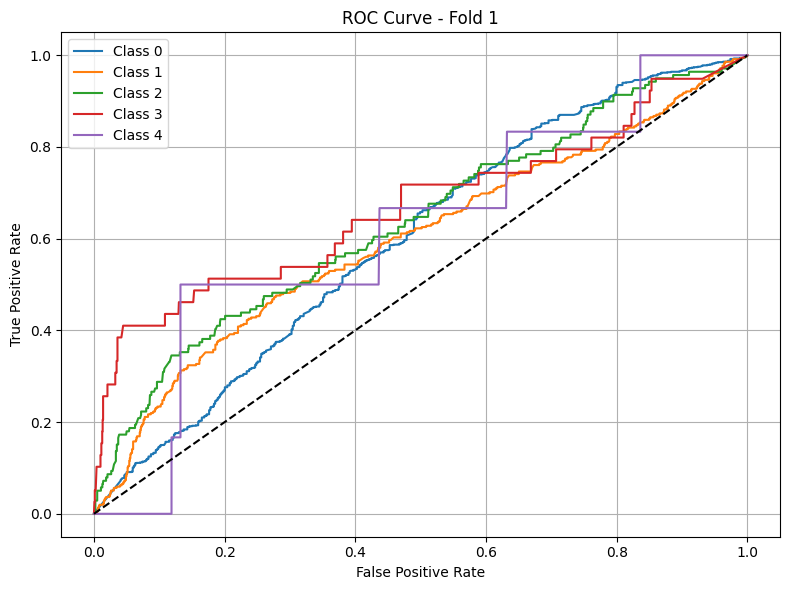


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.93      0.79      1000
           1       0.44      0.19      0.26       355
           2       0.24      0.04      0.06       139
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00         5

    accuracy                           0.65      1539
   macro avg       0.27      0.23      0.22      1539
weighted avg       0.56      0.65      0.58      1539



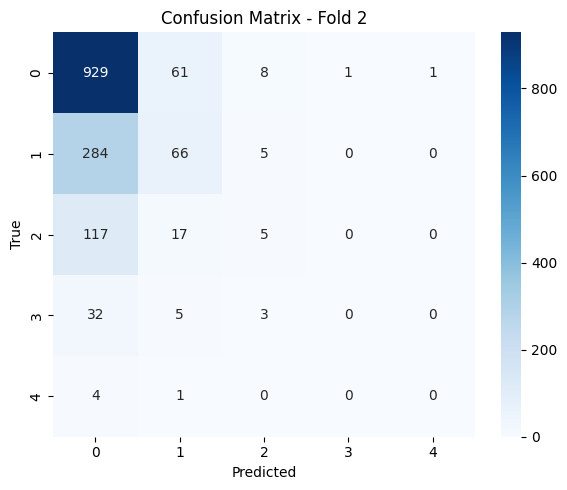

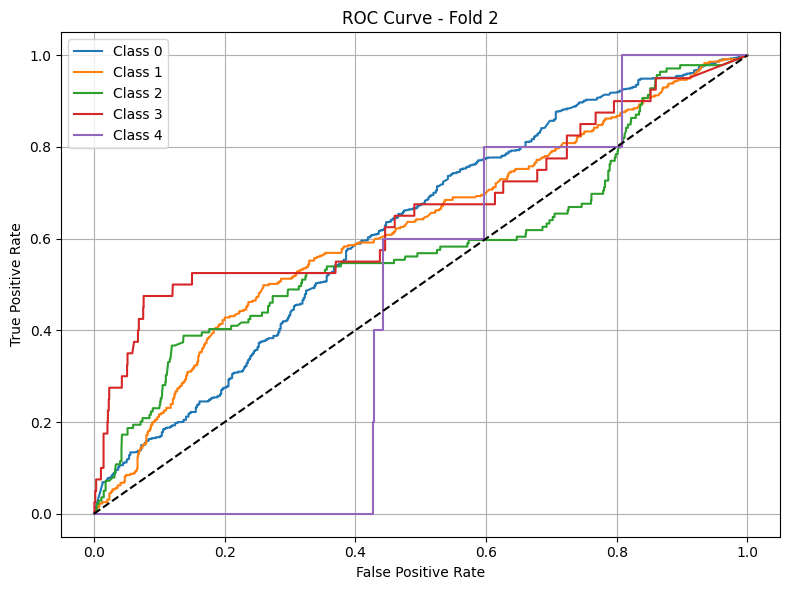

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.91      0.77       999
           1       0.36      0.17      0.23       355
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00         6

    accuracy                           0.63      1539
   macro avg       0.21      0.22      0.20      1539
weighted avg       0.52      0.63      0.55      1539



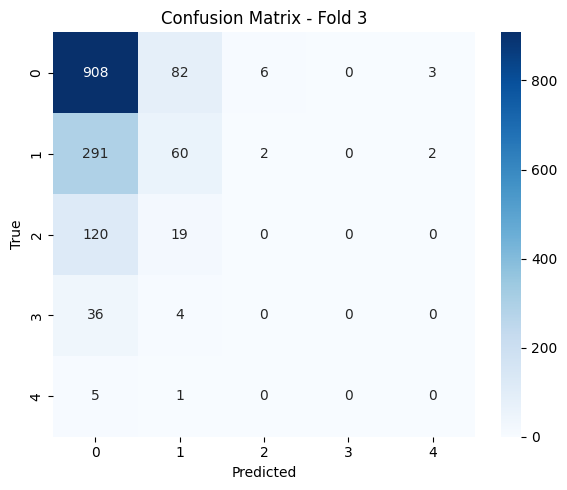

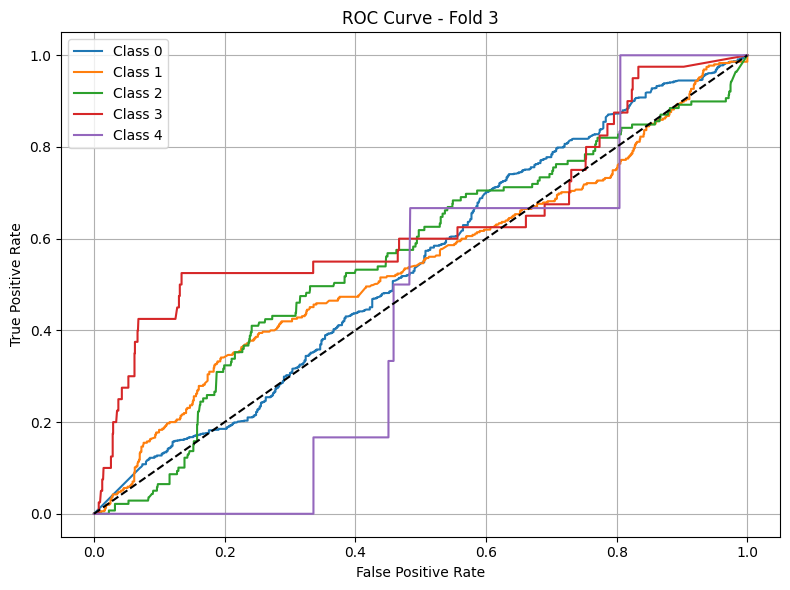


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.95      0.78       999
           1       0.31      0.04      0.07       356
           2       0.21      0.02      0.04       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.63      1538
   macro avg       0.24      0.20      0.18      1538
weighted avg       0.52      0.63      0.52      1538



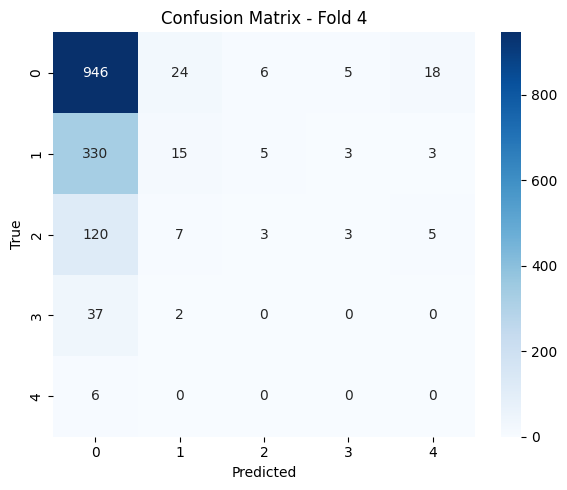

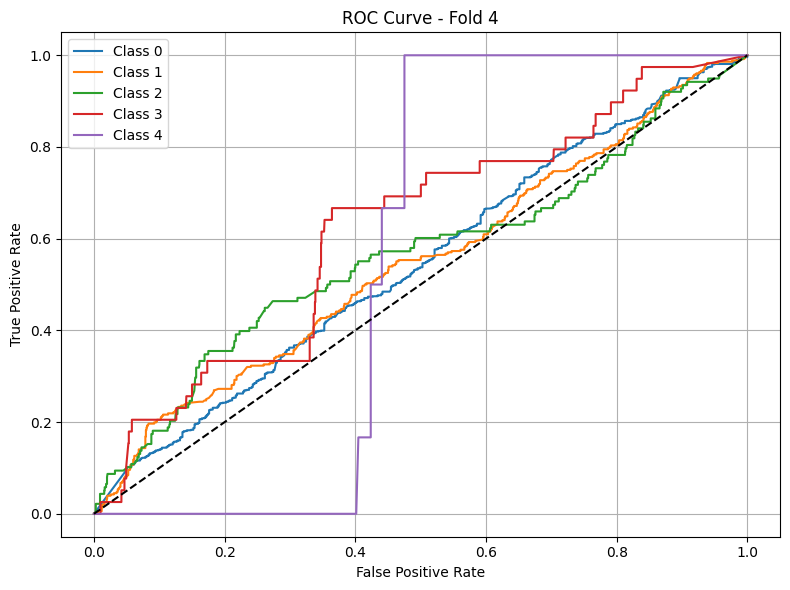

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.95      0.79       999
           1       0.49      0.12      0.20       356
           2       0.12      0.04      0.06       138
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00         6

    accuracy                           0.65      1538
   macro avg       0.26      0.22      0.21      1538
weighted avg       0.56      0.65      0.56      1538



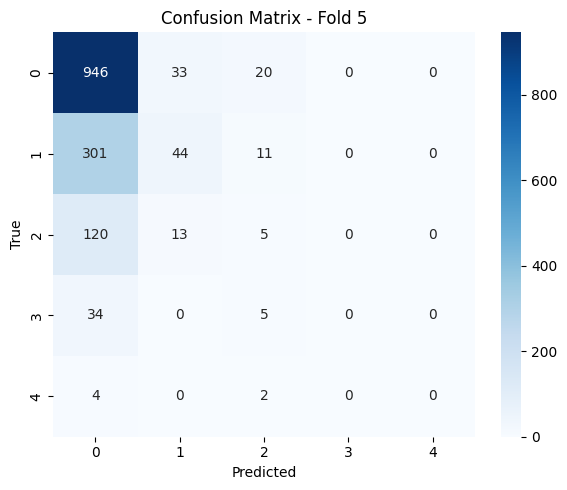

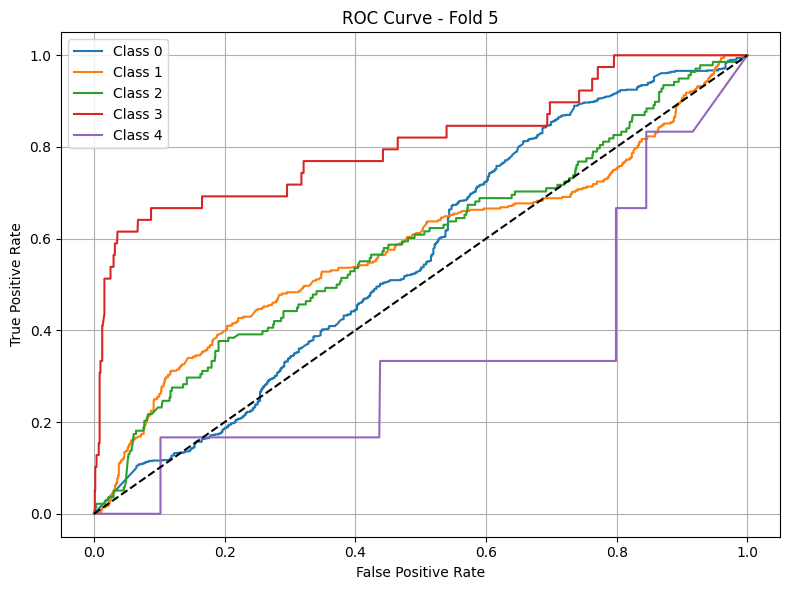


Average Accuracy: 0.6412
Average F1 Macro: 0.2114
Average AUC: 0.5798
{'phase1': [{'fold': 1, 'accuracy': 0.6515653775322283, 'f1_macro': 0.18960350356670835, 'auc': 0.565006558128834}, {'fold': 2, 'accuracy': 0.6481208548268239, 'f1_macro': 0.202340618855892, 'auc': 0.619295875145724}, {'fold': 3, 'accuracy': 0.6171702284450995, 'f1_macro': 0.22587938246882752, 'auc': 0.6401149969171389}, {'fold': 4, 'accuracy': 0.6098010316875461, 'f1_macro': 0.21232425392672938, 'auc': 0.6006235010238729}, {'fold': 5, 'accuracy': 0.6573323507737656, 'f1_macro': 0.2142672628290246, 'auc': 0.6644938923745644}], 'phase2': [{'fold': 1, 'accuracy': 0.6508849557522124, 'f1_macro': 0.19015838044715852, 'auc': 0.6307314397005991}, {'fold': 2, 'accuracy': 0.6535398230088496, 'f1_macro': 0.19635568016261482, 'auc': 0.6290521424753084}, {'fold': 3, 'accuracy': 0.6157591854803011, 'f1_macro': 0.1999548826745387, 'auc': 0.6187533196092444}, {'fold': 4, 'accuracy': 0.6339088092076139, 'f1_macro': 0.2066062552920

In [7]:
import torch

phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")

    sample = False
    # Save best model state_dict and scaler
    sample_tag = "sample" if sample else "no_sample"
    best_model_state, best_scaler, best_label_encoder, metrics = train_phase(phase_path, sample=sample)
    torch.save(best_model_state, f"best_model_state_{sample_tag}_phase{i}.pt")
    joblib.dump(best_scaler, f"best_scaler_{sample_tag}_phase{i}.pkl")
    joblib.dump(best_label_encoder, f"label_encoder_{sample_tag}_phase{i}.pkl")

    results[f"phase{i}"] = metrics
    print(results)



Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.73      0.79       568
           1       0.13      0.38      0.20        63
           2       0.27      0.14      0.18        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.64       698
   macro avg       0.25      0.25      0.23       698
weighted avg       0.72      0.64      0.67       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


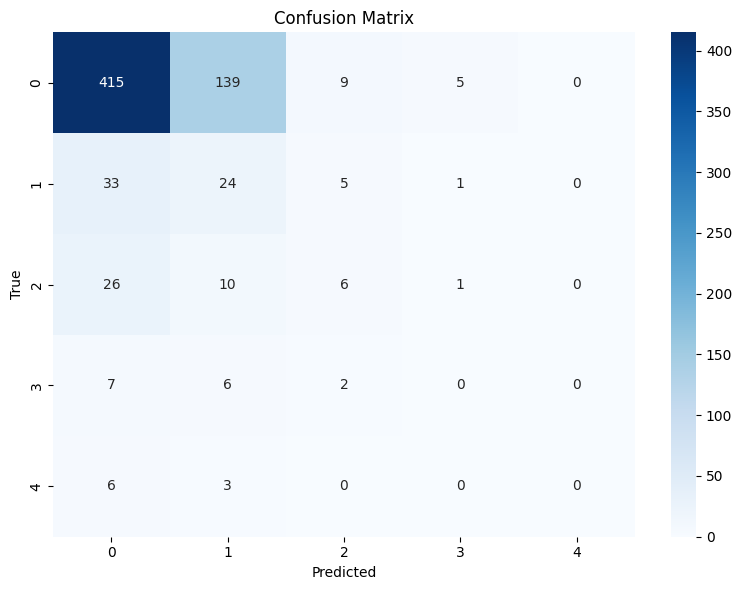


Test AUC (macro-average, OVR): 0.5022


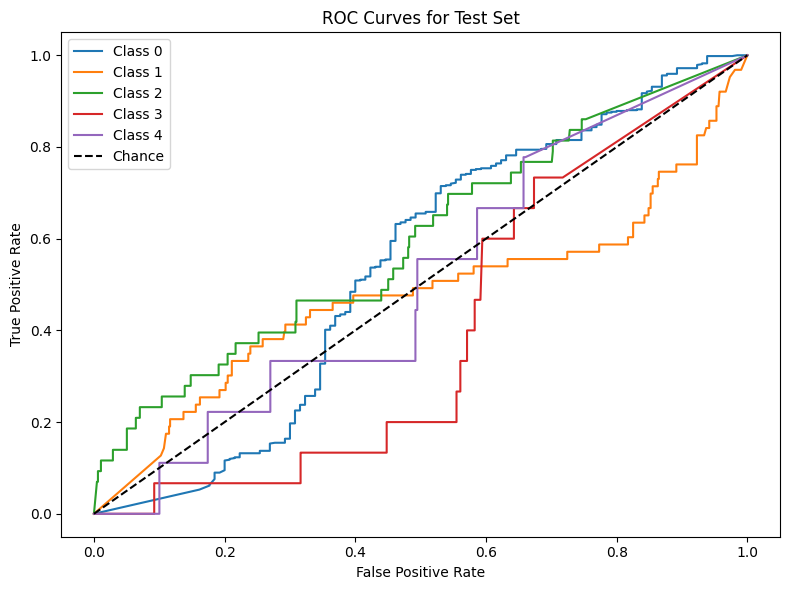


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       544
           1       0.12      0.02      0.03        59
           2       0.24      0.24      0.24        42
           3       0.12      0.07      0.09        14
           4       0.00      0.00      0.00         9

    accuracy                           0.80       668
   macro avg       0.27      0.26      0.25       668
weighted avg       0.73      0.80      0.76       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


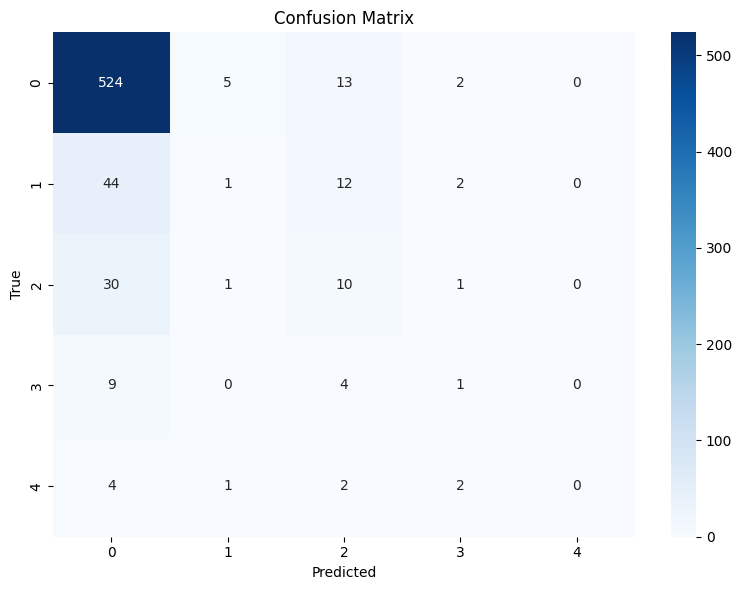


Test AUC (macro-average, OVR): 0.4882


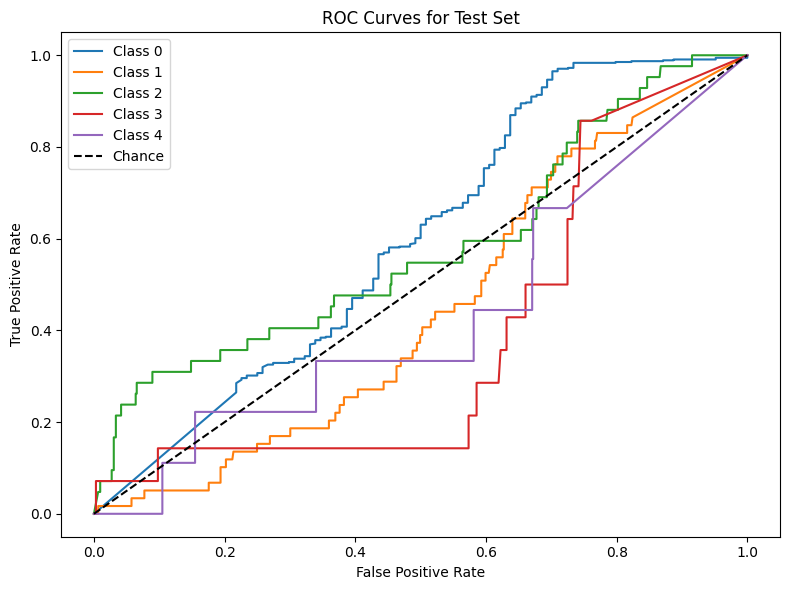


Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.65      0.72       455
           1       0.05      0.02      0.03        52
           2       0.04      0.24      0.07        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.55       554
   macro avg       0.18      0.18      0.16       554
weighted avg       0.67      0.55      0.60       554



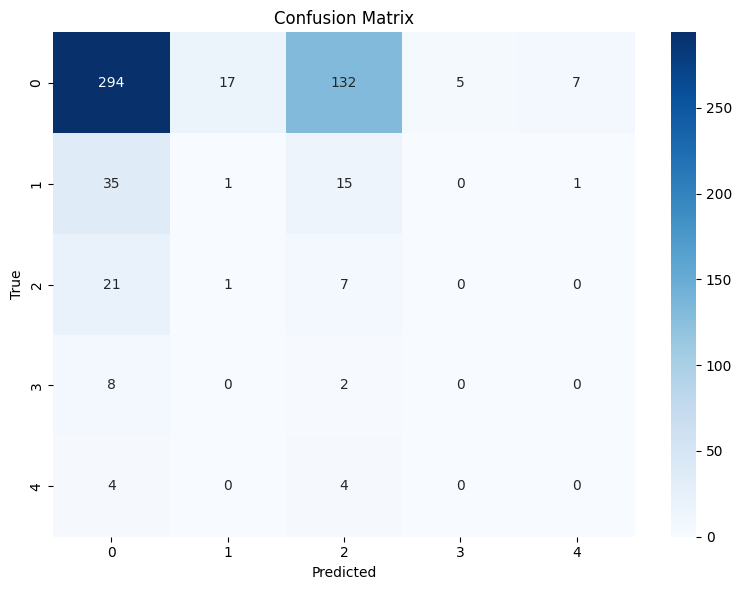


Test AUC (macro-average, OVR): 0.4036


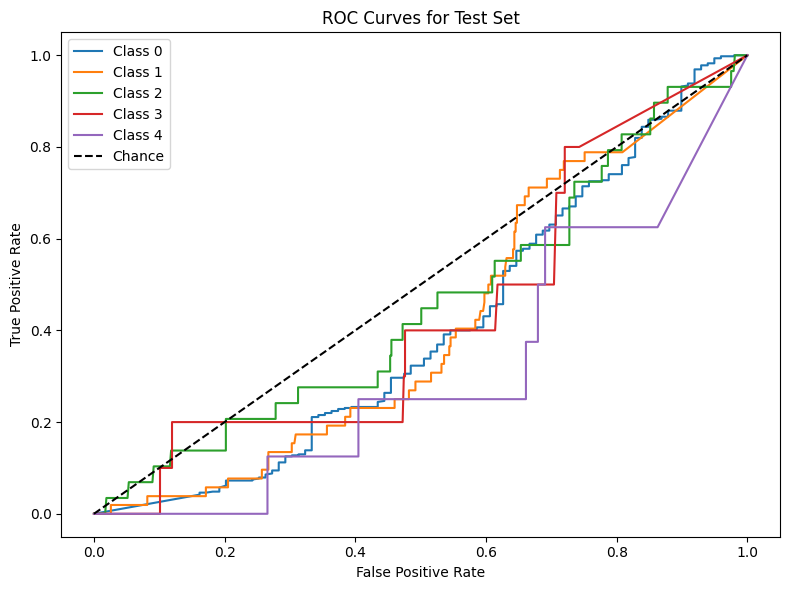


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       395
           1       0.10      0.30      0.15        40
           2       0.11      0.17      0.14        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.62       477
   macro avg       0.22      0.23      0.21       477
weighted avg       0.73      0.62      0.66       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


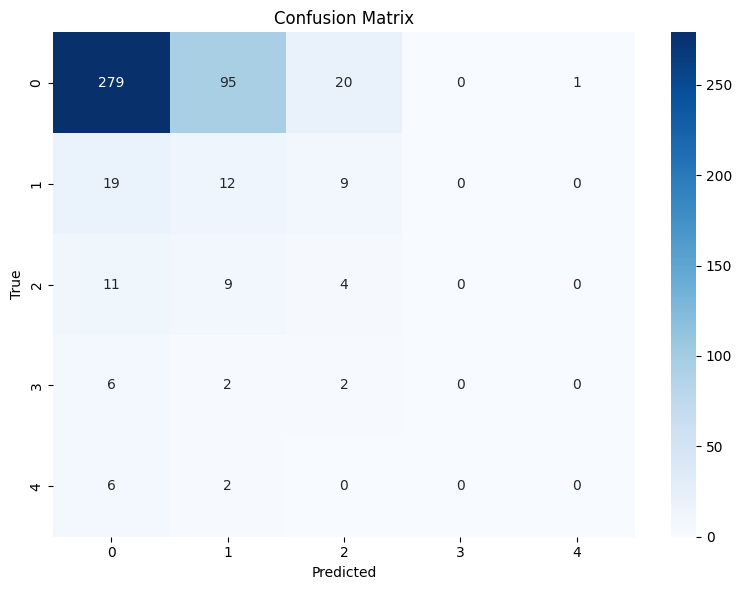


Test AUC (macro-average, OVR): 0.4580


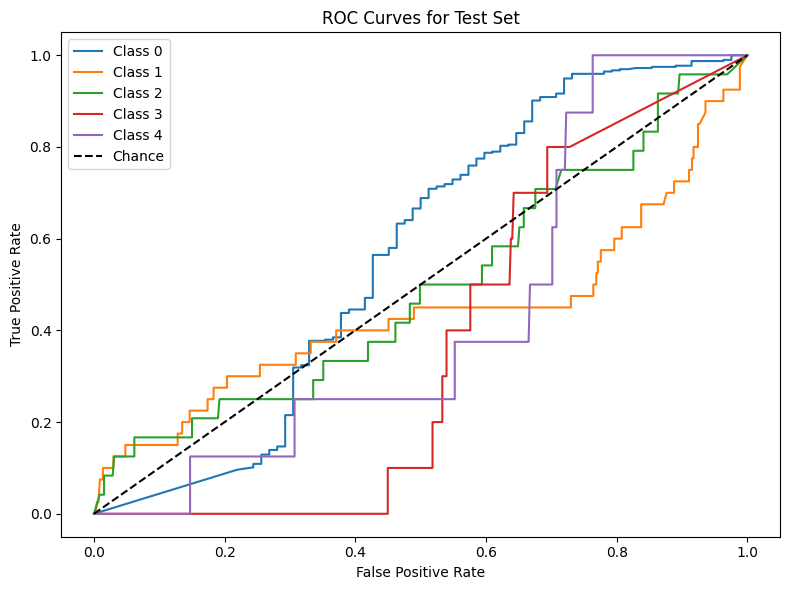

In [8]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_state_{sample_tag}_phase{i}.pt'
    scaler_path = f'/kaggle/working/best_scaler_{sample_tag}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'
    
    label_encoder_dir = f"/kaggle/working/label_encoder_{sample_tag}_phase{i}.pkl"

    # Predict on test set
    y_preds = evaluate_gnn_on_test(
        test_file_path = test_dir,
        model_class=GATModel,
        model_state_dict=model_path,
        scaler_file=scaler_path,
        label_encoder_file = label_encoder_dir,
        school_mapping_file=school_mapping_file,
        k=5
    )


# Sample Data



======= Training Phase 1 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.46      0.59      1785
           1       0.33      0.46      0.39       604
           2       0.23      0.43      0.30       258
           3       0.12      0.51      0.19        59
           4       0.03      0.44      0.06         9

    accuracy                           0.46      2715
   macro avg       0.30      0.46      0.30      2715
weighted avg       0.63      0.46      0.50      2715



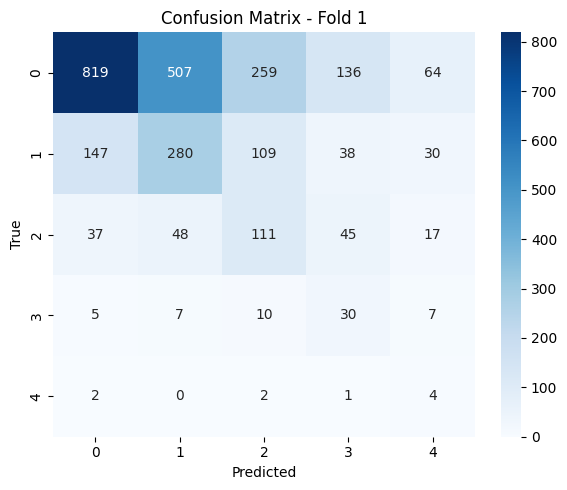

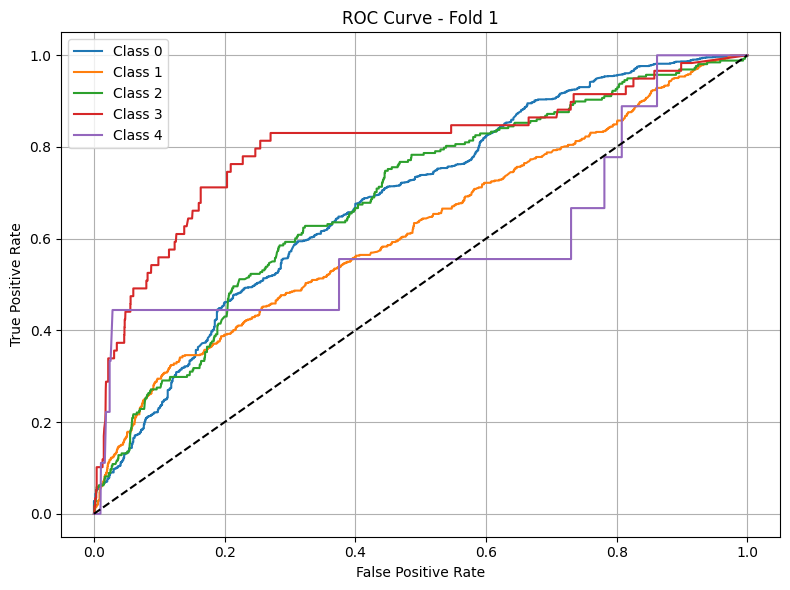


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.49      0.60      1786
           1       0.35      0.39      0.37       603
           2       0.21      0.33      0.26       258
           3       0.10      0.68      0.17        59
           4       0.03      0.38      0.06         8

    accuracy                           0.45      2714
   macro avg       0.29      0.45      0.29      2714
weighted avg       0.61      0.45      0.50      2714



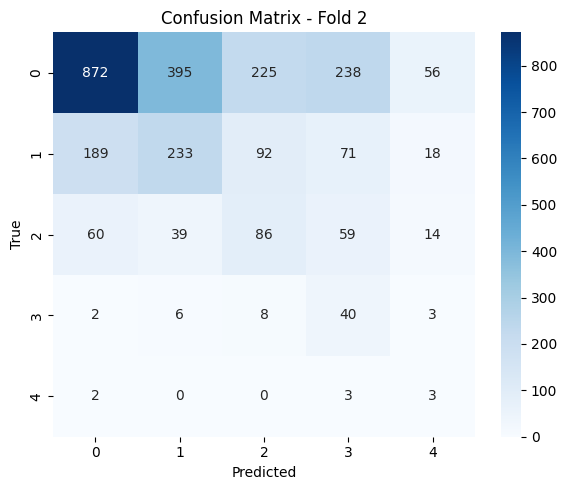

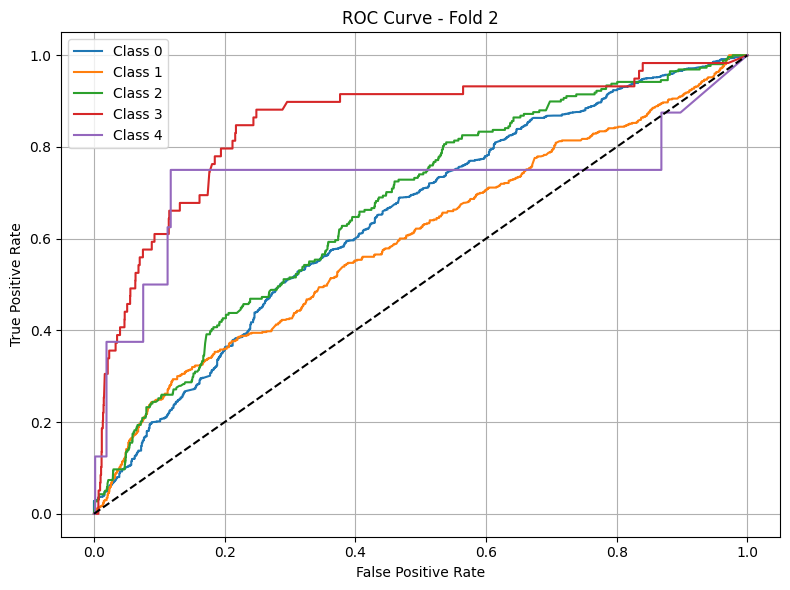


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.62      1786
           1       0.33      0.29      0.31       603
           2       0.19      0.38      0.25       258
           3       0.10      0.59      0.17        59
           4       0.03      0.38      0.05         8

    accuracy                           0.46      2714
   macro avg       0.28      0.43      0.28      2714
weighted avg       0.60      0.46      0.50      2714



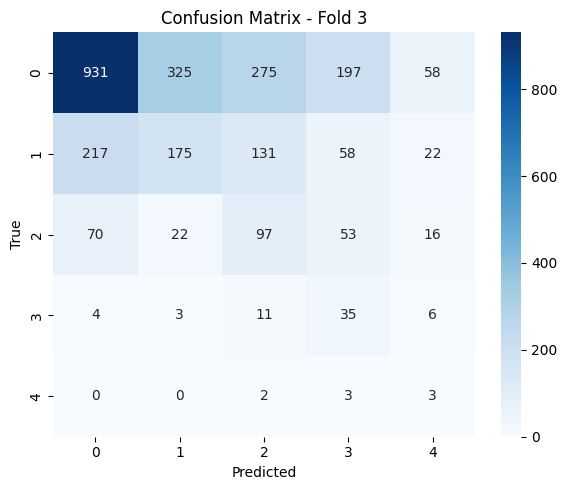

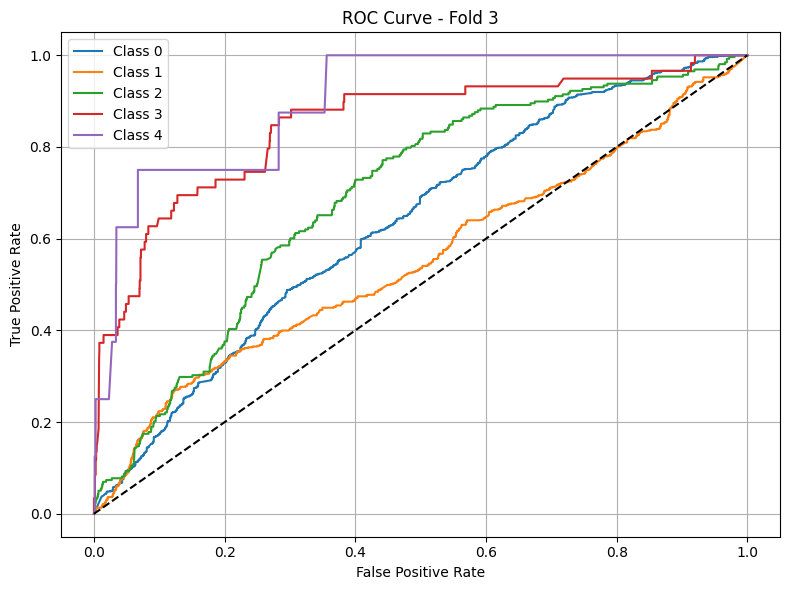


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.49      0.61      1785
           1       0.37      0.38      0.38       603
           2       0.15      0.38      0.22       258
           3       0.10      0.49      0.17        59
           4       0.05      0.56      0.09         9

    accuracy                           0.46      2714
   macro avg       0.30      0.46      0.29      2714
weighted avg       0.64      0.46      0.51      2714



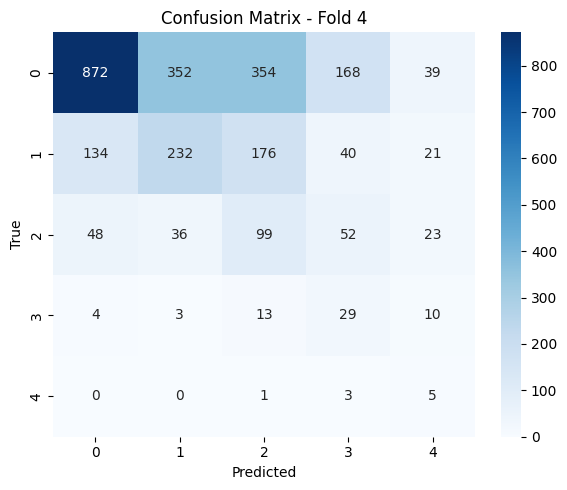

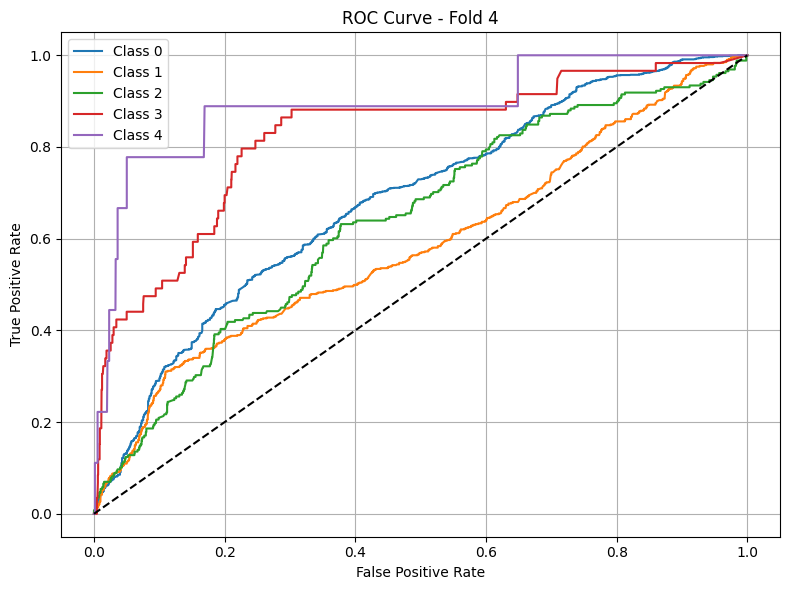


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.40      0.53      1785
           1       0.30      0.36      0.33       603
           2       0.19      0.38      0.26       258
           3       0.10      0.66      0.17        59
           4       0.03      0.56      0.05         9

    accuracy                           0.39      2714
   macro avg       0.28      0.47      0.27      2714
weighted avg       0.61      0.39      0.45      2714



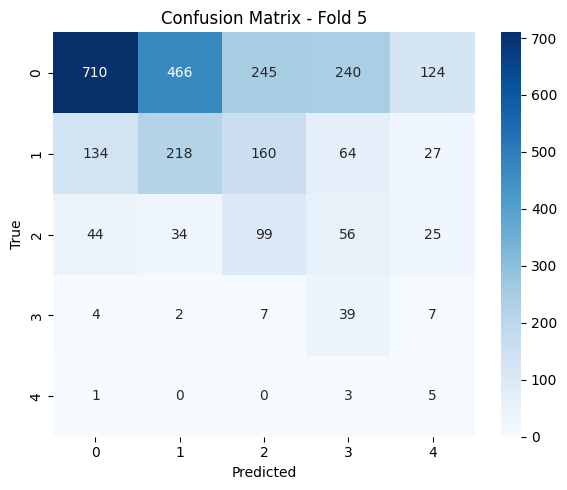

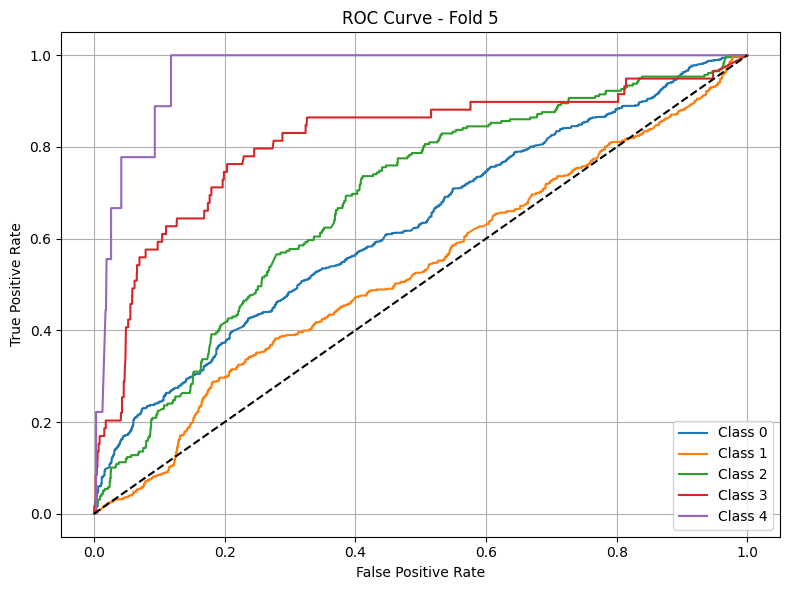


Average Accuracy: 0.4441
Average F1 Macro: 0.2876
Average AUC: 0.7097
{'phase1': [{'fold': 1, 'accuracy': 0.458195211786372, 'f1_macro': 0.30499208136760364, 'auc': 0.6779503079621636}, {'fold': 2, 'accuracy': 0.4546794399410464, 'f1_macro': 0.2900894085480625, 'auc': 0.6988687284121438}, {'fold': 3, 'accuracy': 0.4572586588061901, 'f1_macro': 0.2811764983055391, 'auc': 0.7249804608074195}, {'fold': 4, 'accuracy': 0.4557848194546794, 'f1_macro': 0.29407180093329144, 'auc': 0.7242468078563932}, {'fold': 5, 'accuracy': 0.394620486366986, 'f1_macro': 0.2674473115744361, 'auc': 0.7225851364237142}]}


======= Training Phase 2 ========


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.47      0.58      1489
           1       0.33      0.37      0.35       488
           2       0.18      0.35      0.23       220
           3       0.12      0.63      0.20        54
           4       0.06      0.56      0.11         9

 

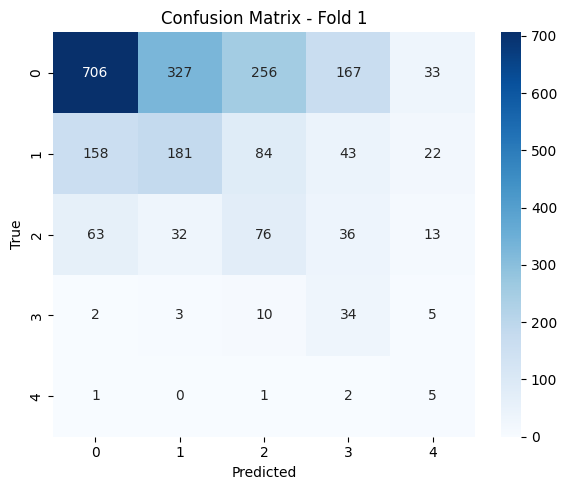

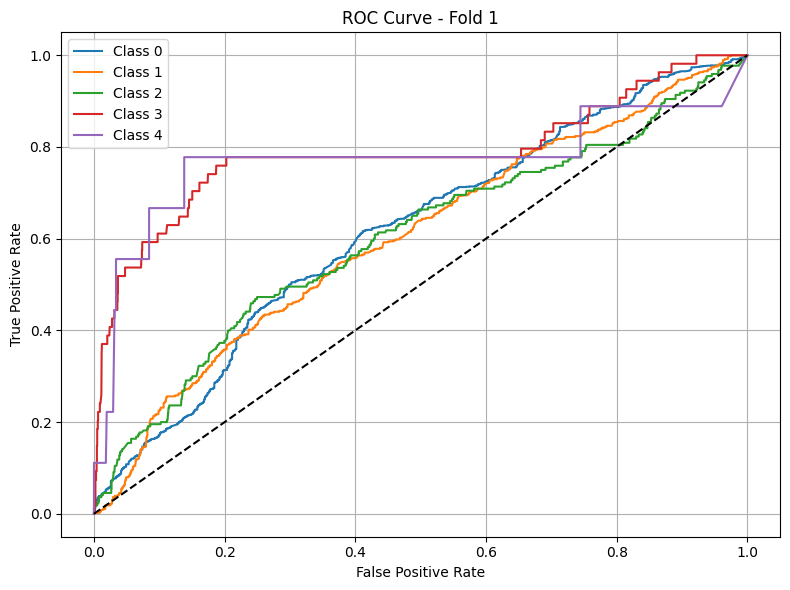


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.46      0.58      1489
           1       0.31      0.45      0.36       489
           2       0.16      0.27      0.20       219
           3       0.12      0.60      0.20        55
           4       0.09      0.50      0.16         8

    accuracy                           0.44      2260
   macro avg       0.30      0.46      0.30      2260
weighted avg       0.61      0.44      0.49      2260



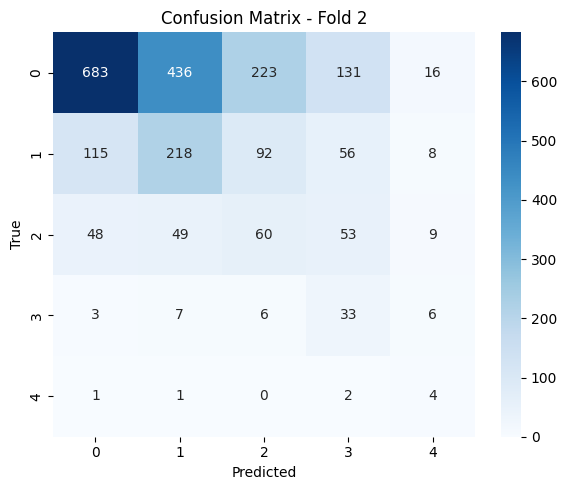

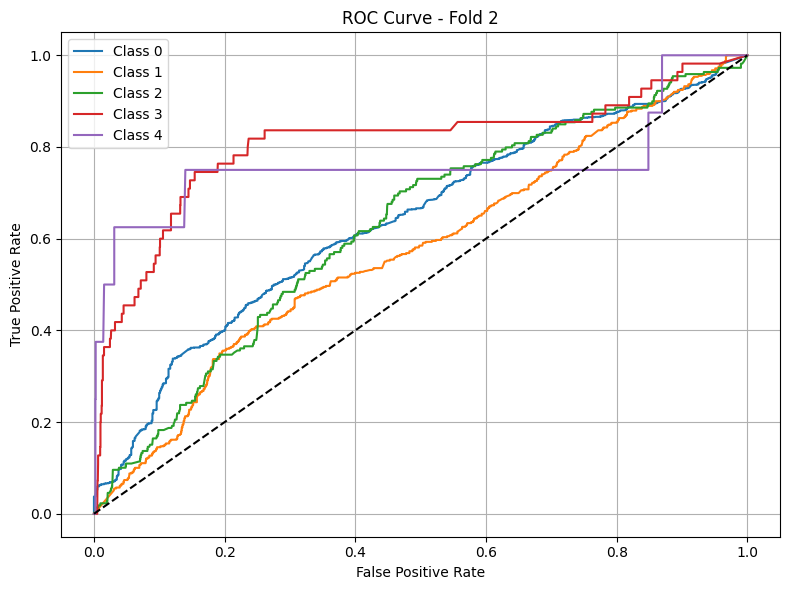


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.53      0.63      1489
           1       0.31      0.41      0.35       489
           2       0.22      0.38      0.28       219
           3       0.13      0.43      0.20        54
           4       0.06      0.62      0.11         8

    accuracy                           0.48      2259
   macro avg       0.30      0.47      0.32      2259
weighted avg       0.61      0.48      0.52      2259



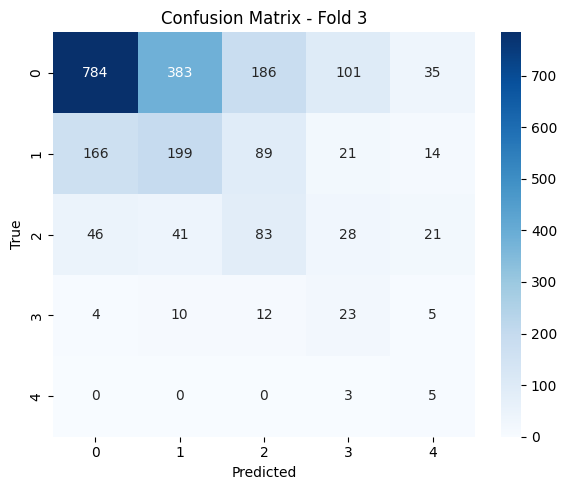

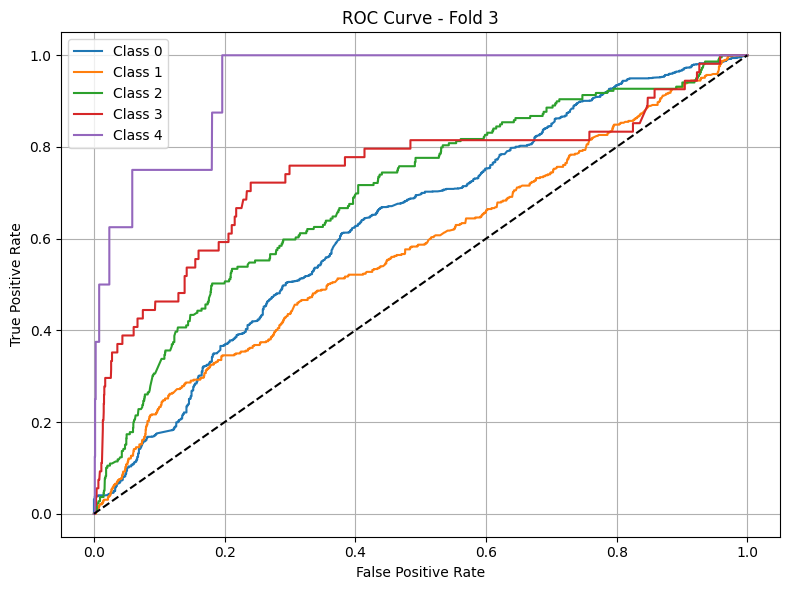


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.44      0.57      1489
           1       0.33      0.39      0.36       489
           2       0.16      0.34      0.21       219
           3       0.15      0.69      0.25        54
           4       0.03      0.38      0.05         8

    accuracy                           0.43      2259
   macro avg       0.29      0.45      0.29      2259
weighted avg       0.61      0.43      0.48      2259



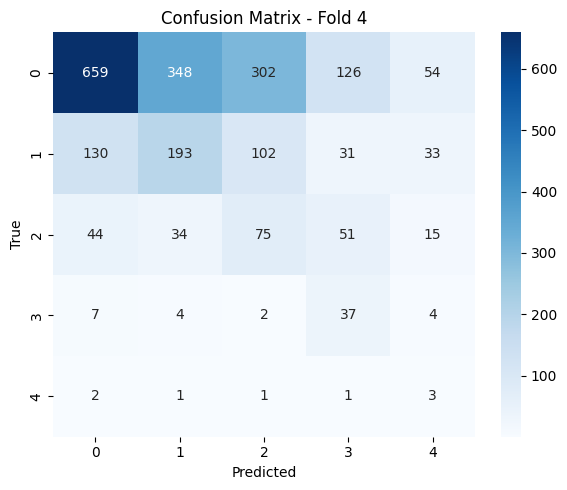

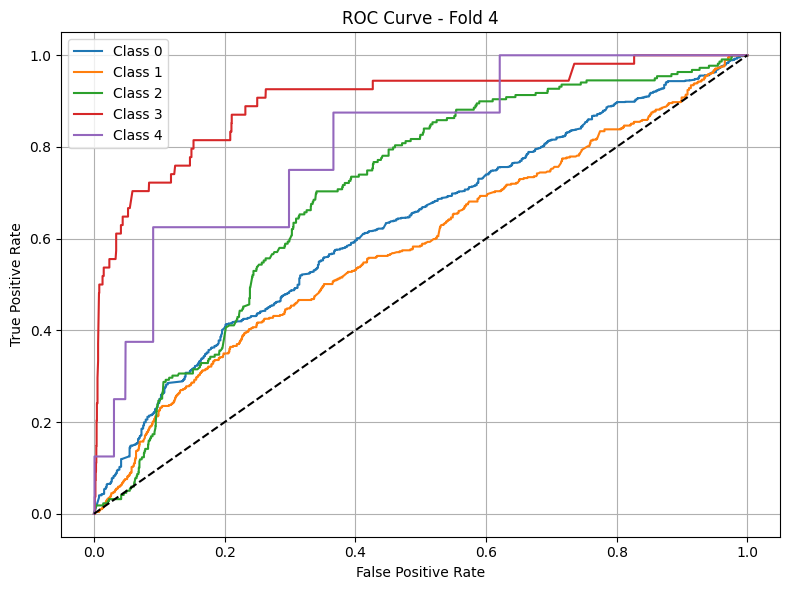


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.46      0.58      1490
           1       0.29      0.38      0.32       488
           2       0.23      0.47      0.31       219
           3       0.13      0.52      0.21        54
           4       0.05      0.50      0.10         8

    accuracy                           0.44      2259
   macro avg       0.29      0.46      0.30      2259
weighted avg       0.59      0.44      0.49      2259



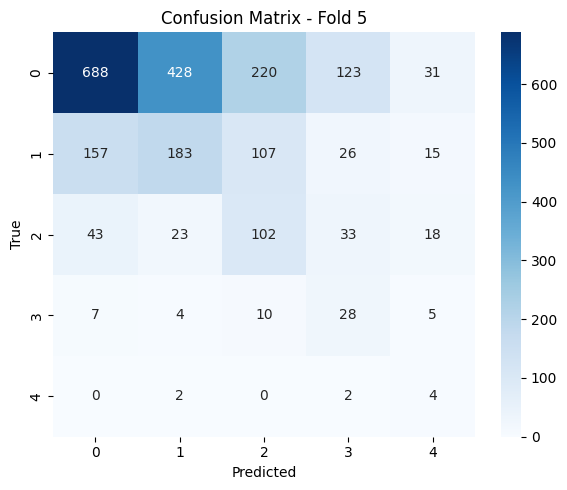

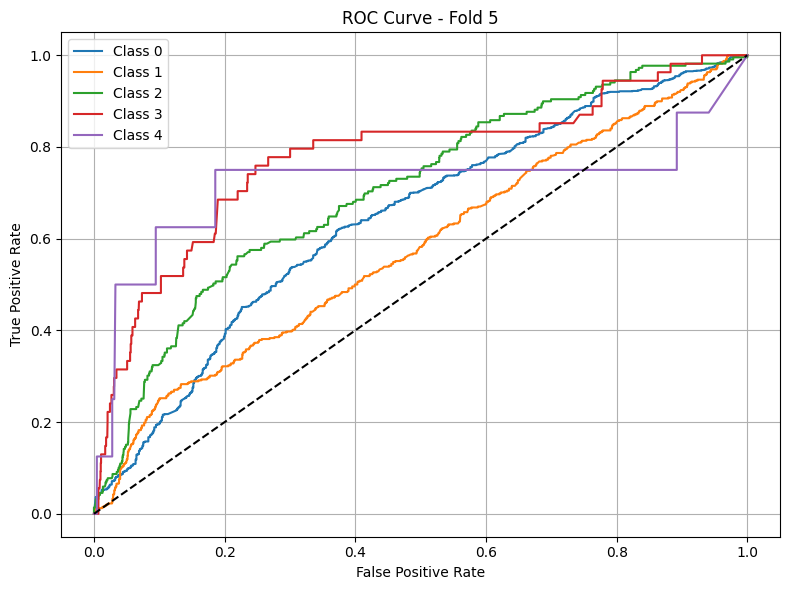


Average Accuracy: 0.4484
Average F1 Macro: 0.3012
Average AUC: 0.6977
{'phase1': [{'fold': 1, 'accuracy': 0.458195211786372, 'f1_macro': 0.30499208136760364, 'auc': 0.6779503079621636}, {'fold': 2, 'accuracy': 0.4546794399410464, 'f1_macro': 0.2900894085480625, 'auc': 0.6988687284121438}, {'fold': 3, 'accuracy': 0.4572586588061901, 'f1_macro': 0.2811764983055391, 'auc': 0.7249804608074195}, {'fold': 4, 'accuracy': 0.4557848194546794, 'f1_macro': 0.29407180093329144, 'auc': 0.7242468078563932}, {'fold': 5, 'accuracy': 0.394620486366986, 'f1_macro': 0.2674473115744361, 'auc': 0.7225851364237142}], 'phase2': [{'fold': 1, 'accuracy': 0.4433628318584071, 'f1_macro': 0.297416325812072, 'auc': 0.6761455281645158}, {'fold': 2, 'accuracy': 0.4415929203539823, 'f1_macro': 0.30084126784531684, 'auc': 0.681872423267962}, {'fold': 3, 'accuracy': 0.48428508189464364, 'f1_macro': 0.31603311277111673, 'auc': 0.7202612134107991}, {'fold': 4, 'accuracy': 0.42806551571491813, 'f1_macro': 0.2876872876376

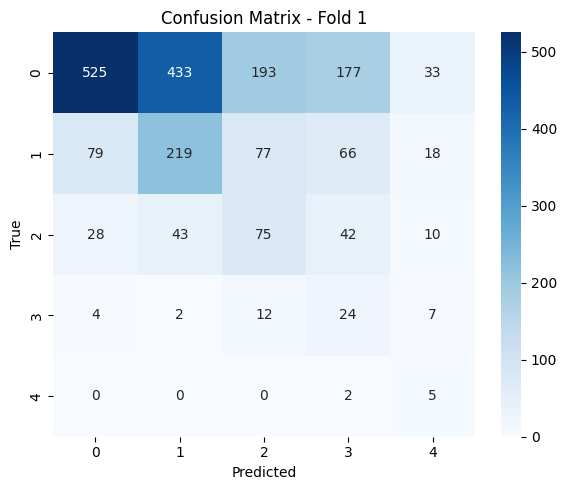

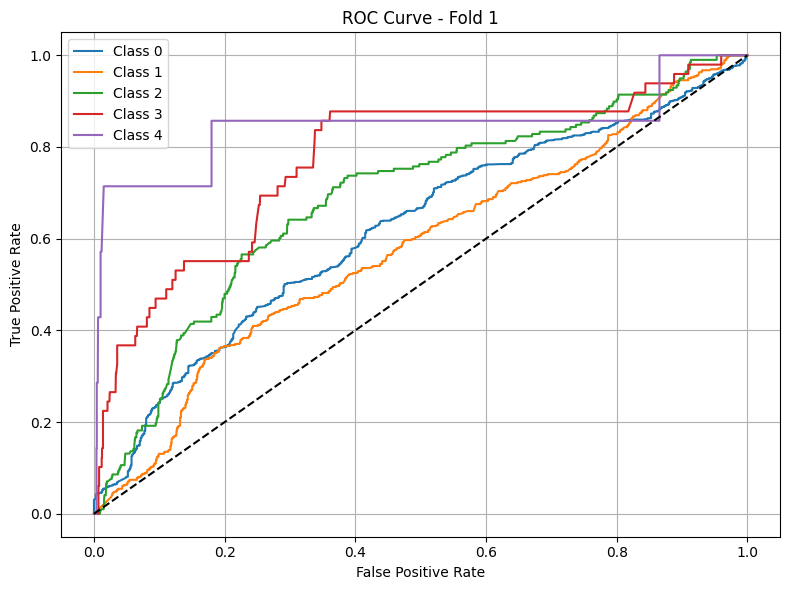


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60      1360
           1       0.31      0.37      0.34       459
           2       0.22      0.42      0.29       198
           3       0.17      0.58      0.26        50
           4       0.03      0.29      0.05         7

    accuracy                           0.46      2074
   macro avg       0.29      0.43      0.31      2074
weighted avg       0.59      0.46      0.50      2074



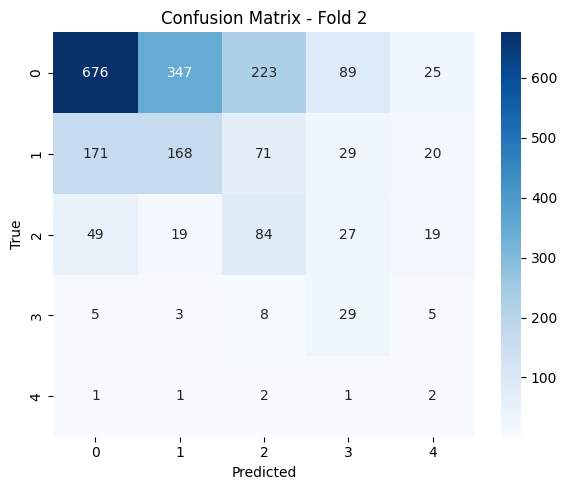

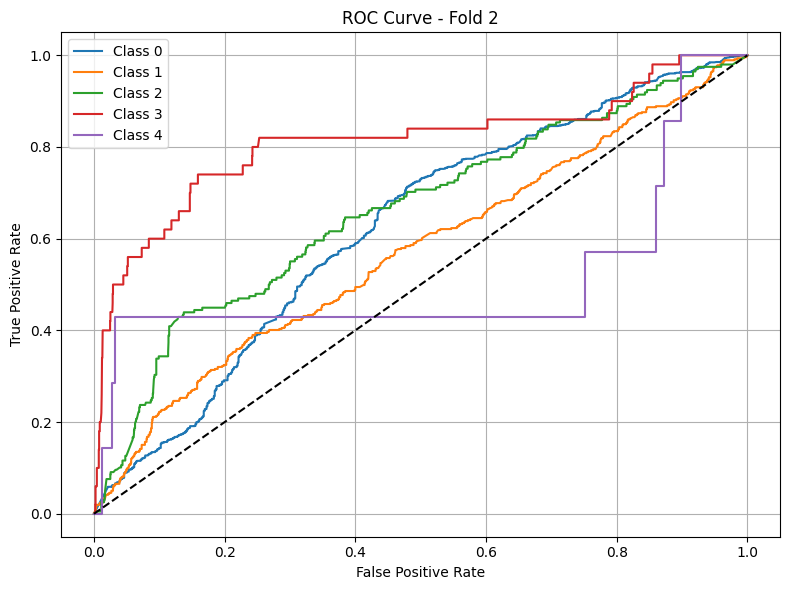


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.46      0.57      1360
           1       0.32      0.37      0.34       459
           2       0.20      0.35      0.25       198
           3       0.10      0.56      0.17        50
           4       0.05      0.43      0.09         7

    accuracy                           0.43      2074
   macro avg       0.28      0.43      0.28      2074
weighted avg       0.58      0.43      0.48      2074



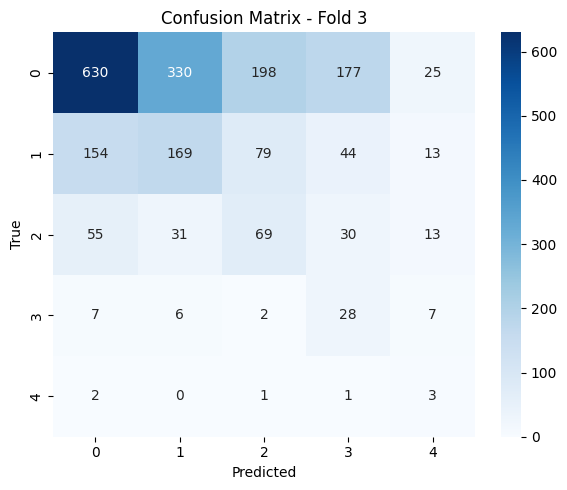

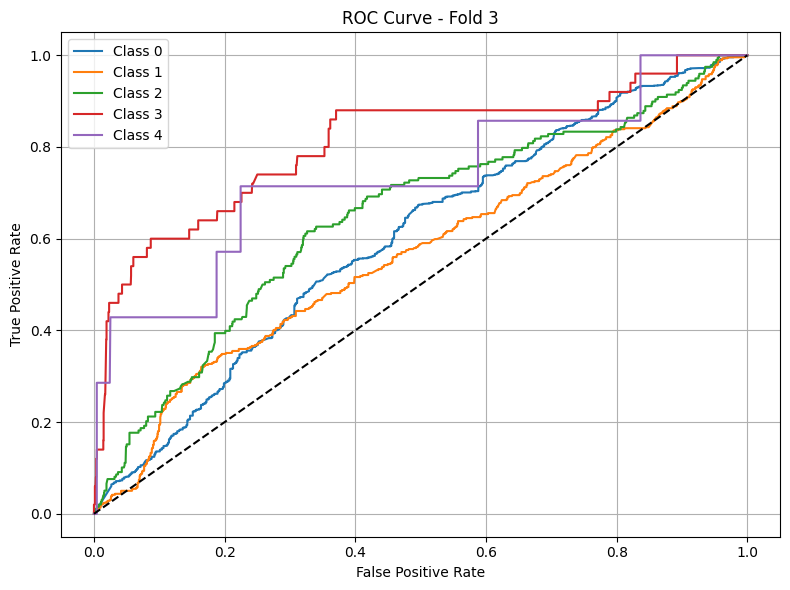


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.43      0.55      1360
           1       0.28      0.39      0.32       459
           2       0.21      0.42      0.28       198
           3       0.13      0.46      0.20        50
           4       0.05      0.71      0.10         7

    accuracy                           0.42      2074
   macro avg       0.29      0.48      0.29      2074
weighted avg       0.59      0.42      0.46      2074



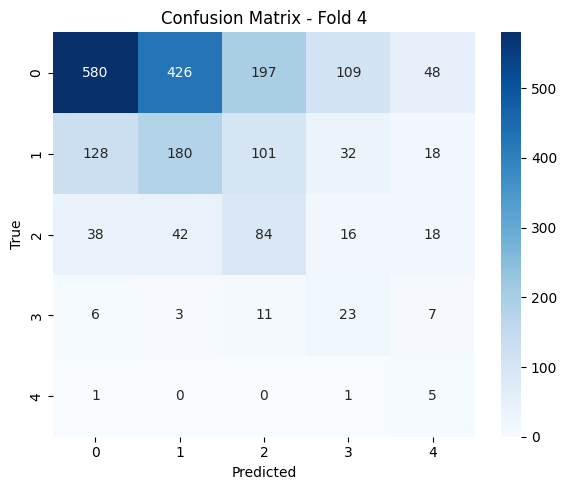

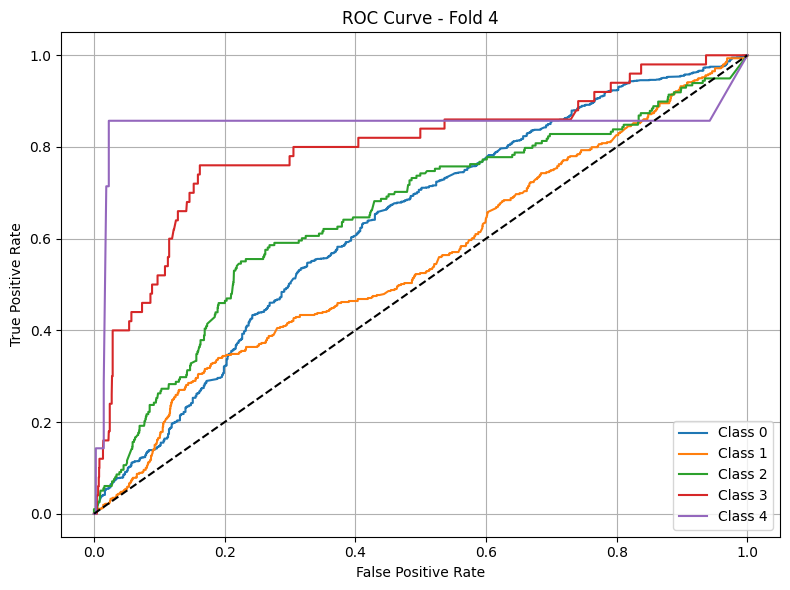


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.43      0.56      1360
           1       0.32      0.38      0.35       460
           2       0.20      0.38      0.26       197
           3       0.11      0.39      0.17        49
           4       0.01      0.43      0.02         7

    accuracy                           0.41      2073
   macro avg       0.29      0.40      0.27      2073
weighted avg       0.61      0.41      0.47      2073



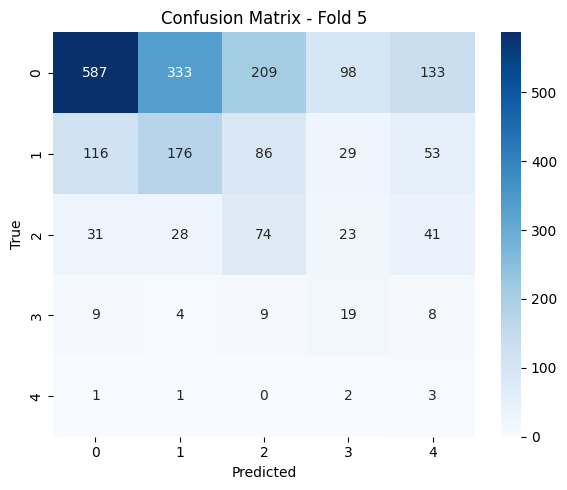

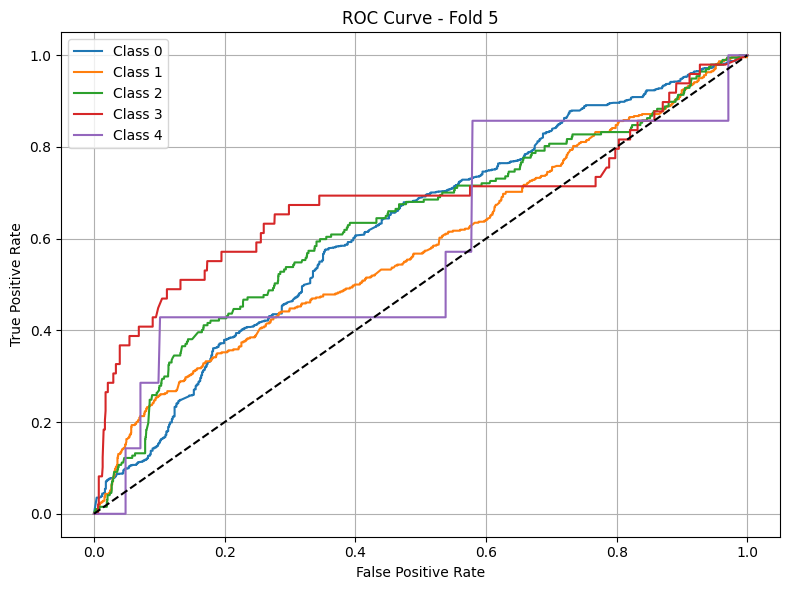


Average Accuracy: 0.4279
Average F1 Macro: 0.2881
Average AUC: 0.6654
{'phase1': [{'fold': 1, 'accuracy': 0.458195211786372, 'f1_macro': 0.30499208136760364, 'auc': 0.6779503079621636}, {'fold': 2, 'accuracy': 0.4546794399410464, 'f1_macro': 0.2900894085480625, 'auc': 0.6988687284121438}, {'fold': 3, 'accuracy': 0.4572586588061901, 'f1_macro': 0.2811764983055391, 'auc': 0.7249804608074195}, {'fold': 4, 'accuracy': 0.4557848194546794, 'f1_macro': 0.29407180093329144, 'auc': 0.7242468078563932}, {'fold': 5, 'accuracy': 0.394620486366986, 'f1_macro': 0.2674473115744361, 'auc': 0.7225851364237142}], 'phase2': [{'fold': 1, 'accuracy': 0.4433628318584071, 'f1_macro': 0.297416325812072, 'auc': 0.6761455281645158}, {'fold': 2, 'accuracy': 0.4415929203539823, 'f1_macro': 0.30084126784531684, 'auc': 0.681872423267962}, {'fold': 3, 'accuracy': 0.48428508189464364, 'f1_macro': 0.31603311277111673, 'auc': 0.7202612134107991}, {'fold': 4, 'accuracy': 0.42806551571491813, 'f1_macro': 0.2876872876376

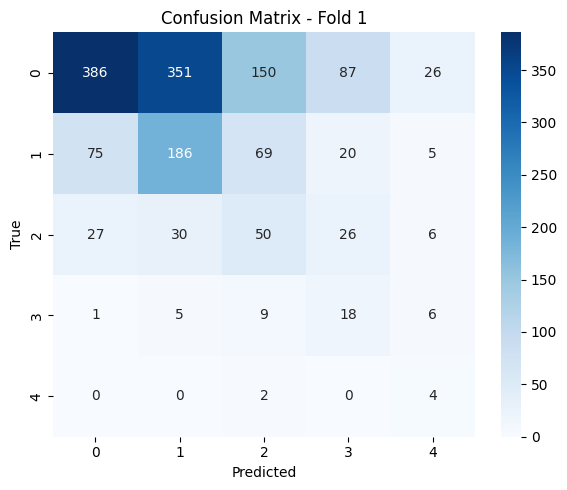

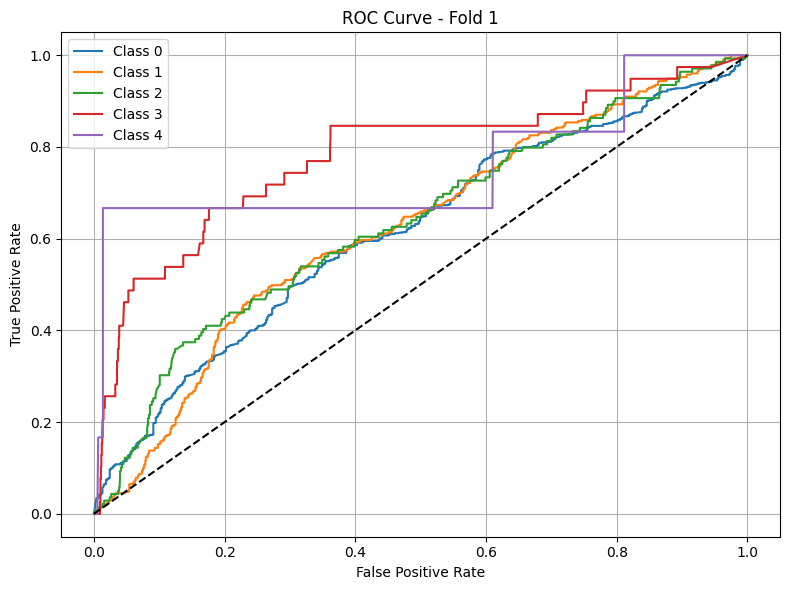


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.53      0.62      1000
           1       0.42      0.41      0.41       355
           2       0.18      0.30      0.22       139
           3       0.13      0.62      0.21        40
           4       0.04      0.40      0.08         5

    accuracy                           0.48      1539
   macro avg       0.30      0.45      0.31      1539
weighted avg       0.60      0.48      0.52      1539



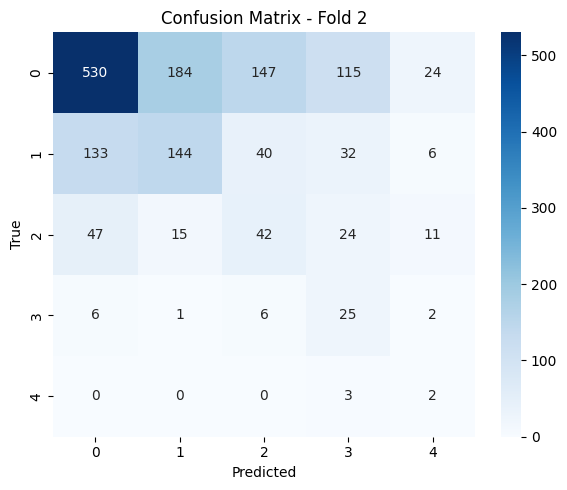

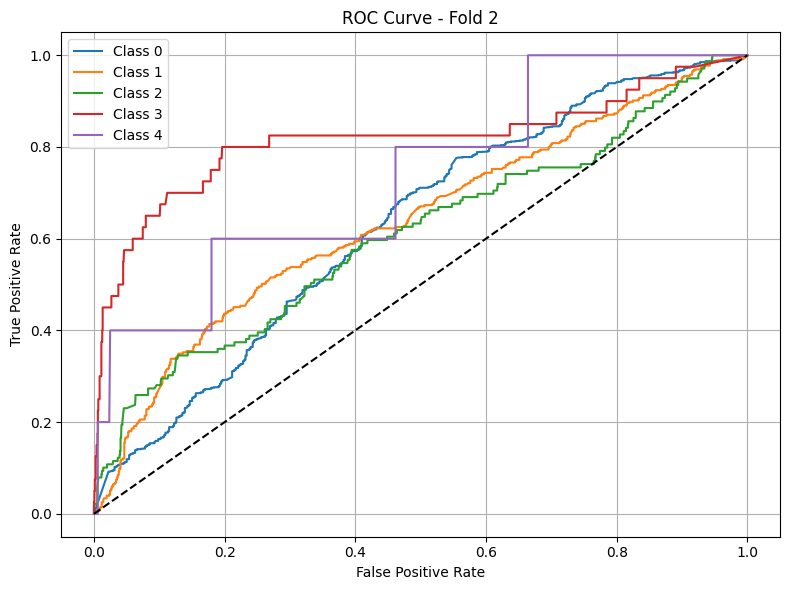


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.46      0.58       999
           1       0.34      0.43      0.38       355
           2       0.20      0.46      0.28       139
           3       0.13      0.45      0.20        40
           4       0.10      0.67      0.17         6

    accuracy                           0.46      1539
   macro avg       0.31      0.49      0.32      1539
weighted avg       0.61      0.46      0.50      1539



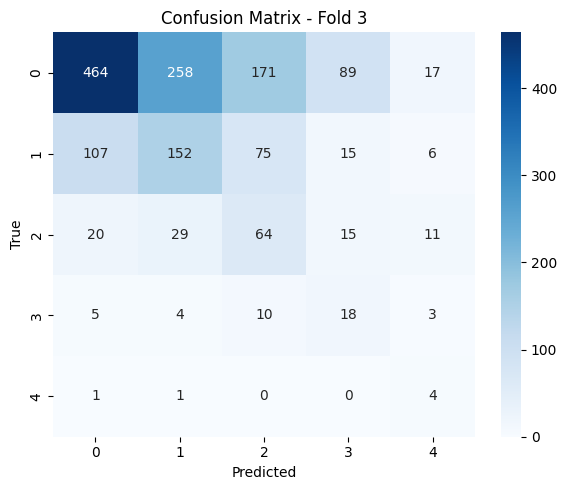

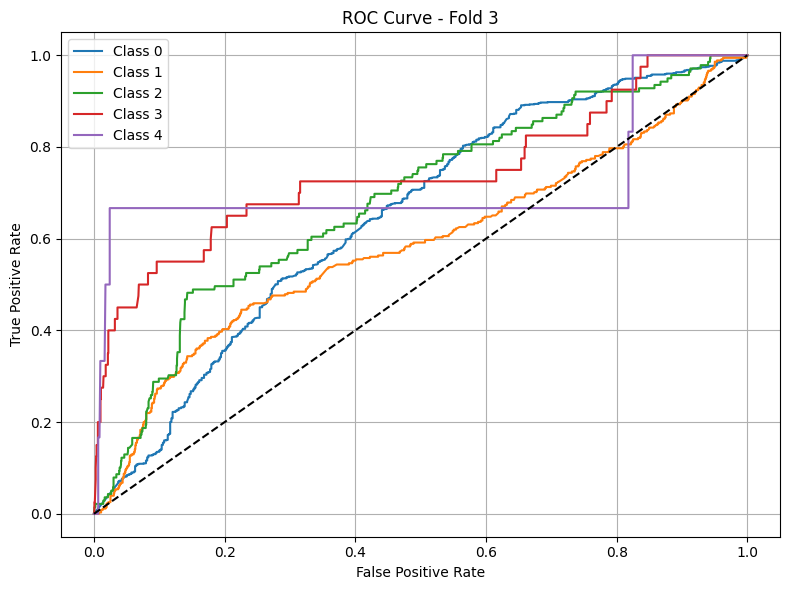


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.52      0.62       999
           1       0.39      0.39      0.39       356
           2       0.17      0.38      0.23       138
           3       0.15      0.51      0.24        39
           4       0.06      0.67      0.11         6

    accuracy                           0.48      1538
   macro avg       0.31      0.49      0.32      1538
weighted avg       0.62      0.48      0.52      1538



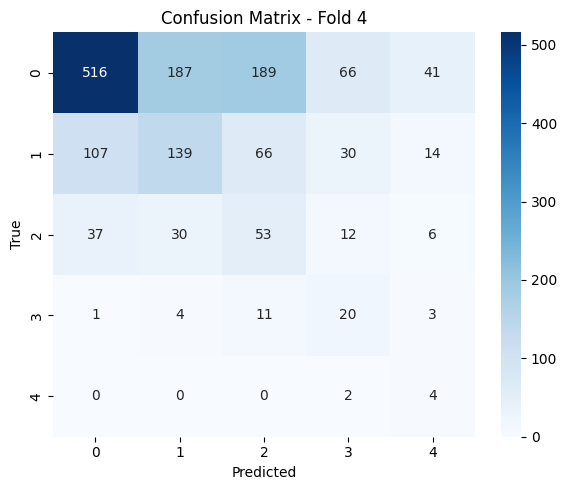

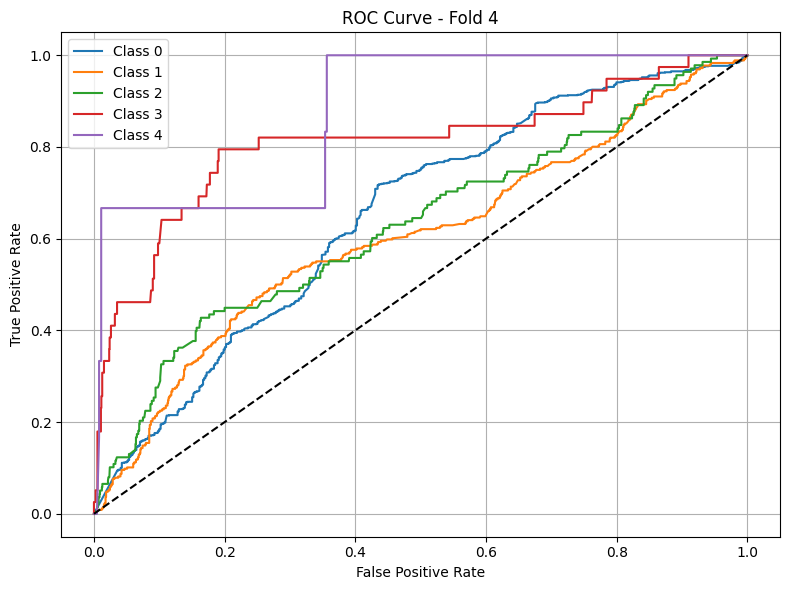


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.46      0.58       999
           1       0.37      0.53      0.44       356
           2       0.18      0.32      0.23       138
           3       0.23      0.69      0.34        39
           4       0.01      0.17      0.03         6

    accuracy                           0.47      1538
   macro avg       0.32      0.44      0.32      1538
weighted avg       0.62      0.47      0.51      1538



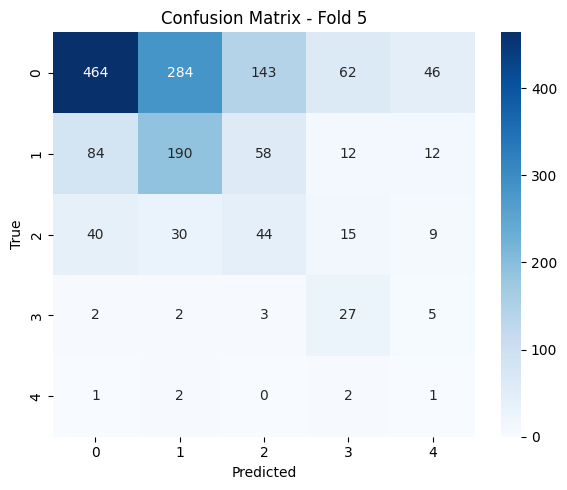

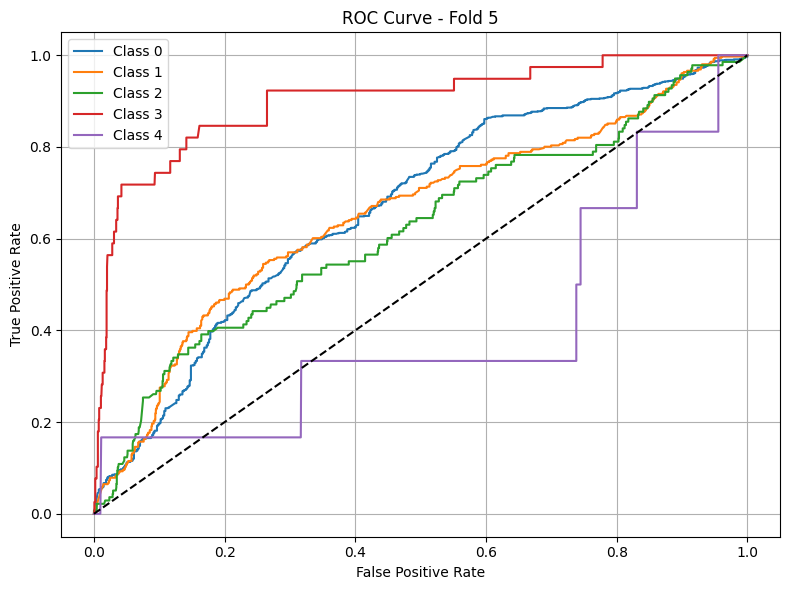


Average Accuracy: 0.4611
Average F1 Macro: 0.3146
Average AUC: 0.6810
{'phase1': [{'fold': 1, 'accuracy': 0.458195211786372, 'f1_macro': 0.30499208136760364, 'auc': 0.6779503079621636}, {'fold': 2, 'accuracy': 0.4546794399410464, 'f1_macro': 0.2900894085480625, 'auc': 0.6988687284121438}, {'fold': 3, 'accuracy': 0.4572586588061901, 'f1_macro': 0.2811764983055391, 'auc': 0.7249804608074195}, {'fold': 4, 'accuracy': 0.4557848194546794, 'f1_macro': 0.29407180093329144, 'auc': 0.7242468078563932}, {'fold': 5, 'accuracy': 0.394620486366986, 'f1_macro': 0.2674473115744361, 'auc': 0.7225851364237142}], 'phase2': [{'fold': 1, 'accuracy': 0.4433628318584071, 'f1_macro': 0.297416325812072, 'auc': 0.6761455281645158}, {'fold': 2, 'accuracy': 0.4415929203539823, 'f1_macro': 0.30084126784531684, 'auc': 0.681872423267962}, {'fold': 3, 'accuracy': 0.48428508189464364, 'f1_macro': 0.31603311277111673, 'auc': 0.7202612134107991}, {'fold': 4, 'accuracy': 0.42806551571491813, 'f1_macro': 0.2876872876376

In [9]:
import torch

phase_paths = [f"/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")

    sample = True
    
    # Save best model state_dict and scaler
    sample_tag = "sample" if sample else "no_sample"
    best_model_state, best_scaler, best_label_encoder, metrics = train_phase(phase_path, sample=sample)
    torch.save(best_model_state, f"best_model_state_{sample_tag}_phase{i}.pt")
    joblib.dump(best_scaler, f"best_scaler_{sample_tag}_phase{i}.pkl")
    joblib.dump(best_label_encoder, f"label_encoder_{sample_tag}_phase{i}.pkl")

    results[f"phase{i}"] = metrics
    print(results)


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.67      0.76       568
           1       0.12      0.30      0.18        63
           2       0.11      0.28      0.16        43
           3       1.00      0.07      0.12        15
           4       0.00      0.00      0.00         9

    accuracy                           0.59       698
   macro avg       0.42      0.26      0.24       698
weighted avg       0.76      0.59      0.65       698



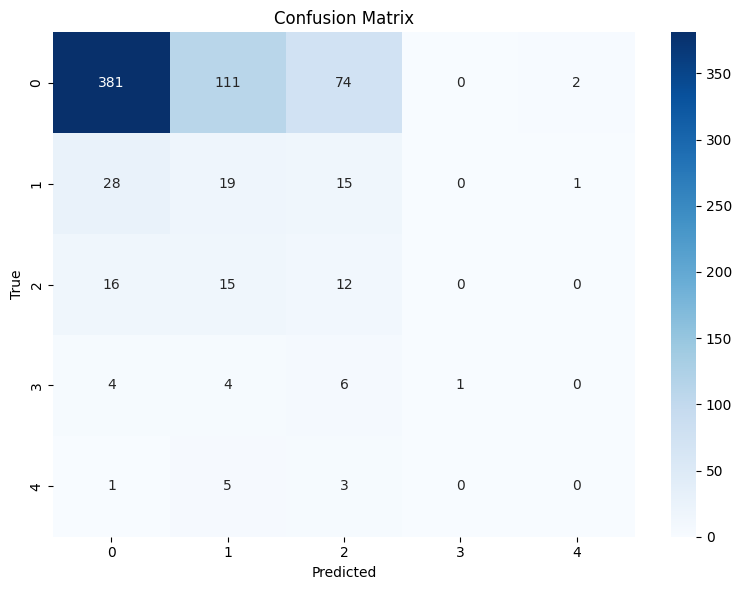


Test AUC (macro-average, OVR): 0.5357


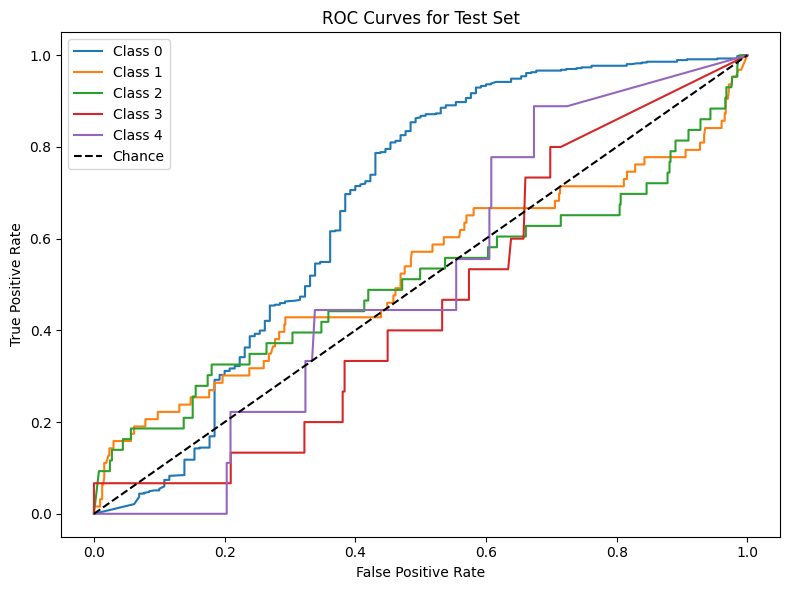


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.74      0.80       544
           1       0.10      0.25      0.15        59
           2       0.13      0.14      0.14        42
           3       0.11      0.07      0.09        14
           4       0.00      0.00      0.00         9

    accuracy                           0.64       668
   macro avg       0.24      0.24      0.23       668
weighted avg       0.72      0.64      0.68       668



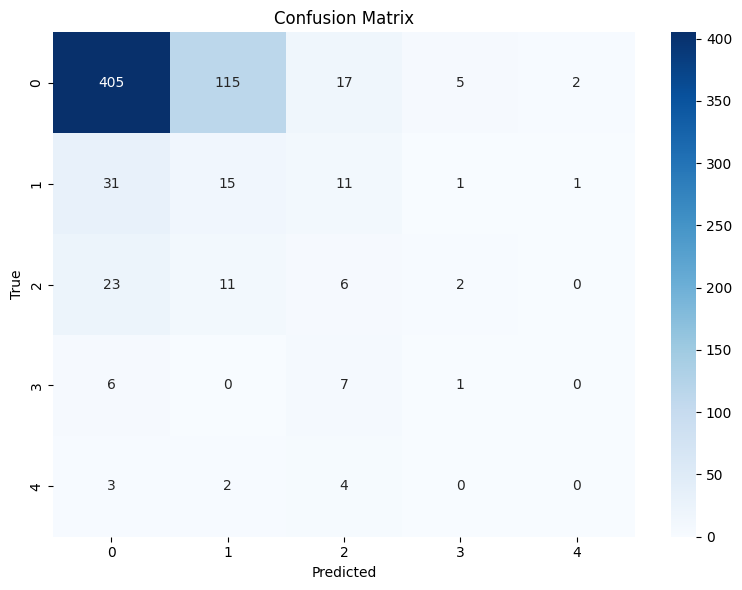


Test AUC (macro-average, OVR): 0.5123


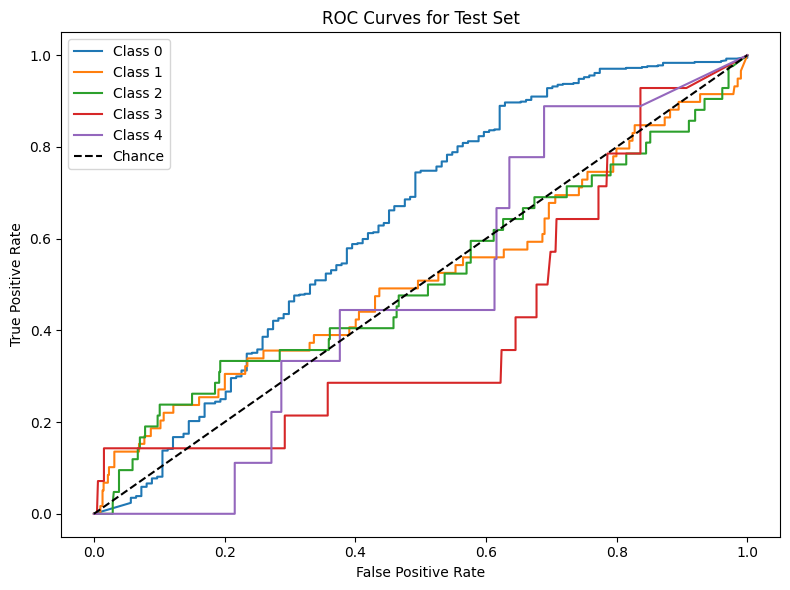


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.49      0.61       455
           1       0.07      0.25      0.11        52
           2       0.16      0.41      0.23        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.44       554
   macro avg       0.21      0.23      0.19       554
weighted avg       0.69      0.44      0.53       554



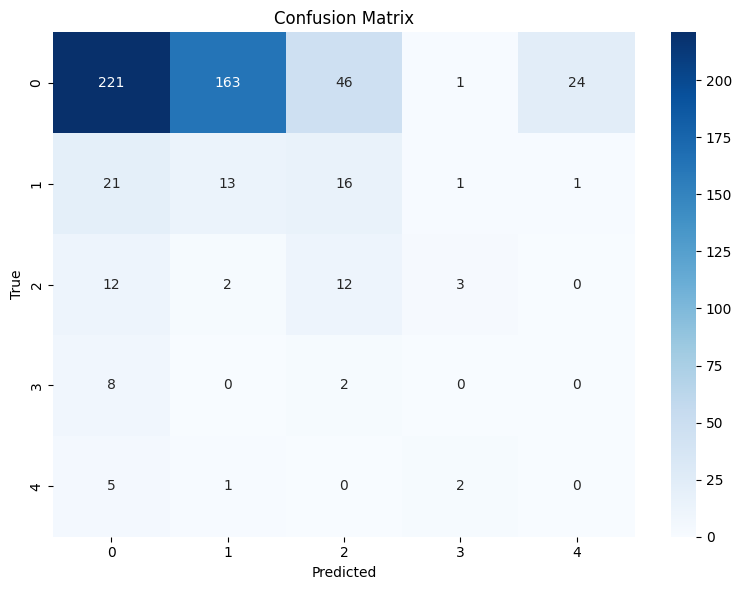


Test AUC (macro-average, OVR): 0.5017


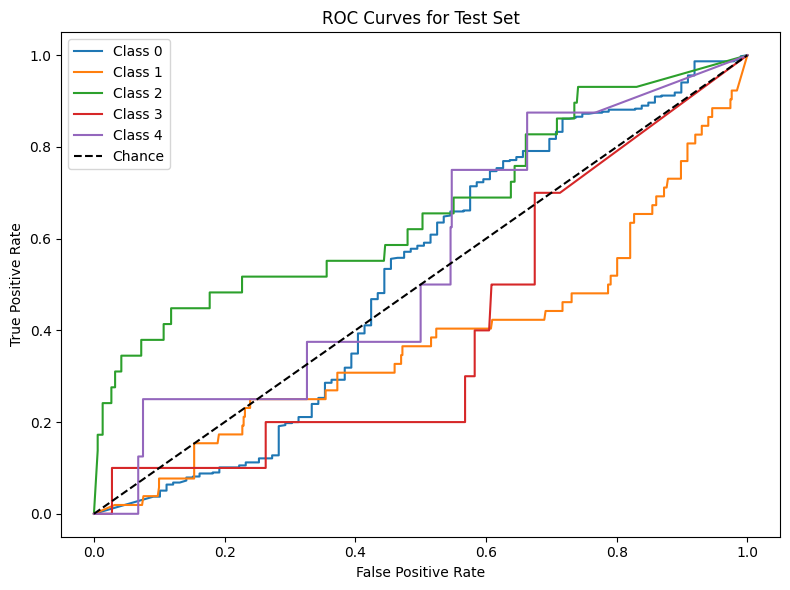


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.47      0.62       395
           1       0.07      0.28      0.11        40
           2       0.06      0.25      0.10        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.43       477
   macro avg       0.20      0.20      0.16       477
weighted avg       0.74      0.43      0.52       477



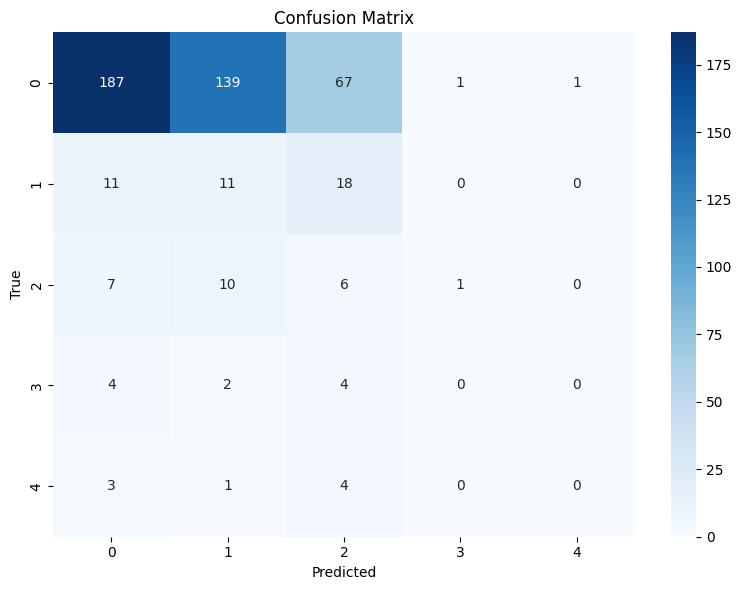


Test AUC (macro-average, OVR): 0.4605


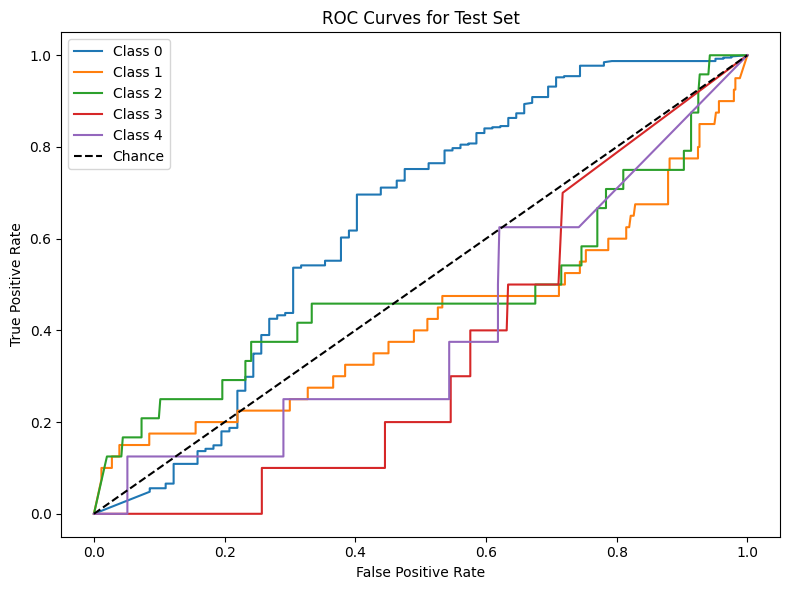

In [10]:
for i in range(1, 5):
    test_dir = f'/kaggle/input/enrich-data-node-clustering/phase{i}/user_train_phase_{i}_test.csv'
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_state_{sample_tag}_phase{i}.pt'
    scaler_path = f'/kaggle/working/best_scaler_{sample_tag}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-enrich-data/outputs/phase{i}/mappings/school_mapping.pkl'
    
    label_encoder_dir = f"/kaggle/working/label_encoder_{sample_tag}_phase{i}.pkl"

    # Predict on test set
    y_preds = evaluate_gnn_on_test(
        test_file_path = test_dir,
        model_class=GATModel,
        model_state_dict=model_path,
        scaler_file=scaler_path,
        label_encoder_file = label_encoder_dir,
        school_mapping_file=school_mapping_file,
        k=5
    )